# Utils

### Libraries

In [83]:
import pandas as pd
import os
import glob
import nibabel as nib
import numpy as np
import contextlib
from sklearn.mixture import GaussianMixture
import warnings
import sys

In [84]:
# Suppress all FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sys.path.append("/Users/emmatosato/Documents/PhD/ANM_Verona/src/data_processing")

In [85]:
import importlib
import data_processing.umap_run as umap_run
import data_processing.umap_clustering as umap_clustering
import data_processing.clustering_evaluation as clustering_evaluation
import data_processing.umap_regression as umap_regression
import data_processing.processing_flat as processing_flat

importlib.reload(umap_run)
importlib.reload(clustering_evaluation)
importlib.reload(umap_regression)
importlib.reload(processing_flat)
importlib.reload(umap_clustering)  # ricarica per ultimo: dipende da umap_run

from data_processing.umap_regression import main_regression
from data_processing.umap_clustering import main_clustering
from data_processing.processing_flat import main_processing_flat
from data_processing.umap_run import x_features_return, run_umap


In [86]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Paths and folders

In [87]:
# FC maps mean
dir_FCmaps = '/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps'
dir_FCmaps_processed = '/data/FCmaps_augmented_processed'
dir_data_utils = "/Users/emmatosato/Documents/PhD/ANM_Verona/data_utils/"
gm_mask_path = '/Users/emmatosato/Documents/PhD/ANM_Verona/utils/masks/GM_mask.nii'
harvard_oxford_mask_path = '/Users/emmatosato/Documents/PhD/ANM_Verona/utils/masks/mask_GM.nii'
atrophy_dataset_matches = '/Users/emmatosato/Documents/PhD/ANM_Verona/utils/metadata/atrophy_matched.xlsx'
cognitive_dataset ='/Users/emmatosato/Documents/PhD/ANM_Verona/utils/metadata/cognitive_dataset.xlsx'

# Data

### Load data

Here:
- Data in nii.gz format are listed
- The subjects identifiers are extracted
- Some asserts on the data are done


In [88]:
def listData_saveID(dir):
    # All nii.gz files in the directory
    files_path = sorted(glob.glob(os.path.join(dir, '*gz')))

    # Extract Subject IDs from filenames
    subject_id = [os.path.basename(f).replace('.FDC.nii.gz', '') for f in files_path]

    # Sanity checks
    assert len(files_path) == len(subject_id), (
        f"Mismatch count: {len(files_path)} files vs {len(subject_id)} IDs"
    )
    assert len(subject_id) == len(set(subject_id)), "ID duplicated"
    for fp, sid in zip(files_path, subject_id):
        fname = os.path.basename(fp)
        expected = sid + '.FDC.nii.gz'
        assert fname == expected, (
            f"Filename “{fname}” do not correspond to the extracted ID“{sid}”"
        )

    print("Check length:")
    print("Files: ", len(files_path))
    print("Subject: ", len(subject_id))

    return files_path, subject_id

In [89]:
files, sub_id = listData_saveID(dir_FCmaps)

Check length:
Files:  176
Subject:  176


In [90]:
maps_FDC = []
for path in files:
    print(path)
    data = nib.load(path).get_fdata().flatten()
    maps_FDC.append(data)

# Stores subjects as rows and voxels as columns
raw_df=pd.DataFrame(maps_FDC)

/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/002_S_4654.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/002_S_6695.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/003_S_6264.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/003_S_6268.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/003_S_6432.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/003_S_6479.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/003_S_6606.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/006_S_6252.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/006_S_6682.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/007_S_6341.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/011_S_4893.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/011_S_6303.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/012_S_4188.FDC.nii.gz

In [91]:
# Insert subjects id
raw_df.insert(0, 'ID', sub_id)
print("\n", raw_df.shape, "\n")


 (176, 902630) 



Some asserts

In [92]:
# Ensure the raw_df has one row per subject ID
assert raw_df.shape[0] == len(sub_id), (
    f"Number of rows ({raw_df.shape[0]}) != number of IDs ({len(sub_id)})"
)

# Verify the ID column matches the original sub_id order exactly
assert raw_df['ID'].tolist() == sub_id, "Row IDs do not match the original sub_id order"

# Confirm there are no duplicate IDs
assert raw_df['ID'].is_unique, "There are duplicate IDs in the DataFrame"

### Metadata

Dataset containing:
- ID of the subject
- The diagnosis (Group)
- Sex
- Age
- Education

The regressors:
- CDR_SB: disease gravity with a larger range
- MMSE: Mini Mental Status
- (CDR: same but smaller range)

The subject 4_S_5003 is removed


In [93]:
# Load the metadata and align to FC map order
df_meta = pd.read_excel(cognitive_dataset, sheet_name='Sheet1')
df_meta['Age'] = df_meta['Age'].round(1)

In [94]:
print("Meta dataset BEFORE removing a subject")
print(df_meta.shape)

# Remove the subject with ID "4_S_5003"
df_meta = df_meta[df_meta['ID'] != '4_S_5003'].reset_index(drop=True)

print("Meta dataset AFTER removing a subject")
print(df_meta.shape)

Meta dataset BEFORE removing a subject
(177, 7)
Meta dataset AFTER removing a subject
(176, 7)


### GMM on CDR_SB

- Assigning each CDB_SB value to a cluster using GMM, removing NaN values of the CDR_SB before
- New column for the metadata dataframe


In [101]:
# Filter valid CDR_SB values
df_cdr = df_meta[['ID', 'CDR_SB']].dropna().copy()
print("Dimensions after dropping NaN", df_cdr.shape)

# Fit GMM and predict raw labels
np.random.seed(42)
x_gmm = df_cdr['CDR_SB'].values.reshape(-1, 1)
gmm = GaussianMixture(n_components=3, random_state=42).fit(x_gmm)
df_cdr['GMM_Label'] = gmm.predict(x_gmm)

# Reorder labels by CDR_SB severity
means = df_cdr.groupby('GMM_Label')['CDR_SB'].mean().sort_values()
label_map = {old: new for new, old in enumerate(means.index)}
df_cdr['GMM_Label'] = df_cdr['GMM_Label'].map(label_map)

# Include in metadata
label_map = dict(zip(df_cdr['ID'], df_cdr['GMM_Label']))
df_meta = df_meta.drop(columns=['GMM_Label'], errors='ignore')
df_meta['GMM_Label'] = df_meta['ID'].map(label_map).astype('Int64')

Dimensions after dropping NaN (168, 2)


In [102]:
print(df_meta['GMM_Label'].value_counts().sort_index())

GMM_Label
0    10
1    62
2    96
Name: count, dtype: Int64


## Yeo Data

In [56]:
# Load csv
df_networks_no_thr = pd.read_csv("/Users/emmatosato/Documents/PhD/ANM_Verona/data/mean_networks/mean_networks_noTHR.csv")
df_networks_thr01 = pd.read_csv("/Users/emmatosato/Documents/PhD/ANM_Verona/data/mean_networks/mean_networks_thr01.csv")
df_networks_thr02 = pd.read_csv("/Users/emmatosato/Documents/PhD/ANM_Verona/data/mean_networks/mean_networks_thr02.csv")

# Code ID
df_networks_no_thr = df_networks_no_thr.rename(columns={"CODE": "ID"})
df_networks_thr01 = df_networks_thr01.rename(columns={"CODE": "ID"})
df_networks_thr02 = df_networks_thr02.rename(columns={"CODE": "ID"})

# Features
features_network = ['VIS_mean', 'VAN_mean', 'DAN_mean', 'DMN_mean', 'LMB_mean', 'FPN_mean', 'SMN_mean', 'SUBCORTICAL_mean']

# Analysis with UMAP

## Preprocessing

In [15]:
print(raw_df.shape,"and the metadata dataframe", df_meta.shape)

(176, 902630) and the metadata dataframe (176, 8)


STEPS:
- Aligning the metadata to the raw_df, and thus removing the subject that have NaN value for the chosen target variable (look at the shape)
- Optional threshold for values below 0.1 and 0.2
- Masking with 2 masks
- Possible output dataset:
    - `df_thr01_gm_masked`
    - `df_thr02_gm_masked`
    - `df_thr01_har_masked`
    - `df_thr02_har_masked`
    - `df_gm_masked`
    - `df_har_masked`


In [16]:
outputs, df_summary = main_processing_flat(
    df=raw_df,
    df_meta=df_meta,
    gm_mask_path=gm_mask_path,
    harvard_mask_path=harvard_oxford_mask_path,
    do_eda=True
)

The IDs are now perfectly aligned...
Thresholds applied...
Masks applied...
Processing completed!


In [17]:
df_thr01_gm_masked   = outputs['thr_01_gm']
df_thr02_gm_masked   = outputs['thr_02_gm']
df_thr01_har_masked  = outputs['thr_01_har']
df_thr02_har_masked  = outputs['thr_02_har']
df_gm_masked         = outputs['gm_no_thr']
df_har_masked        = outputs['har_no_thr']

In [18]:
pd.options.display.float_format = '{:.4f}'.format
display(df_summary)

Shape Values between 0 and 1.0 Zero maps  All Min  \
Dataset                                                                 
thr_01_gm   (176, 161818)                     True  0 of 176   0.0000   
thr_02_gm   (176, 161818)                      NaN  0 of 176   0.0000   
thr_01_har   (176, 55005)                     True  0 of 176   0.0000   
thr_02_har   (176, 55005)                      NaN  8 of 176   0.0000   
gm_no_thr   (176, 161818)                      NaN  0 of 176  -0.2879   
har_no_thr   (176, 55005)                      NaN  0 of 176  -0.1555   

            All Max  All Mean  All Std  Nonzero Min  Nonzero Max  \
Dataset                                                            
thr_01_gm    1.6188    0.0736   0.1022       0.1000       1.6188   
thr_02_gm    1.6188    0.0343   0.0943       0.2000       1.6188   
thr_01_har   1.6188    0.0846   0.1068       0.1000       1.6188   
thr_02_har   1.6188    0.0412   0.1022       0.2000       1.6188   
gm_no_thr    1.6188    0.1000   0.0871      -0.2879       1.6188   
har_no_thr   1.6188    0.1086   0.0916      -0.1555       1.6188   

            Nonzero Mean  Nonzero Std Values between 0 and 2.0  
Dataset                                                         
thr_01_gm         0.1829       0.0771                      NaN  
thr_02_gm         0.2750       0.0715                     True  
thr_01_har        0.1867       0.0783                      NaN  
thr_02_har        0.2754       0.0723                     True  
gm_no_thr         0.1000       0.0871                      NaN  
har_no_thr        0.1086       0.0916                      NaN

## Unsupervised Clustering

- About the input
    - DataFrame that have been processed
    - The metadata
    - Possibility to save the plot
    - Title of the 2 plots, embeddings and clustering
    - Possibility to plot
    - Possibility to evaluate the clustering
    - Possibility to save the plot of the clustering
- UMAP for dimensionality reduction
- Clustering evalaution
- Clustering
- Plots

### FC Maps

In [81]:
path_opt_cluster = "/Users/emmatosato/Documents/PhD/ANM_Verona/output/umap_optimal_clusters"
path_umap = "/Users/emmatosato/Documents/PhD/ANM_Verona/output/umap_cluster"
plot_flag_cluster = True

Dataframe shape after merge: (176, 161825)
Meta columns: 8
Feature matrix shape: (176, 161817)


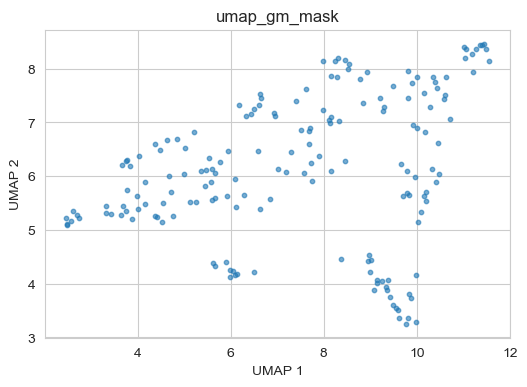


Evaluating clustering algorithms...


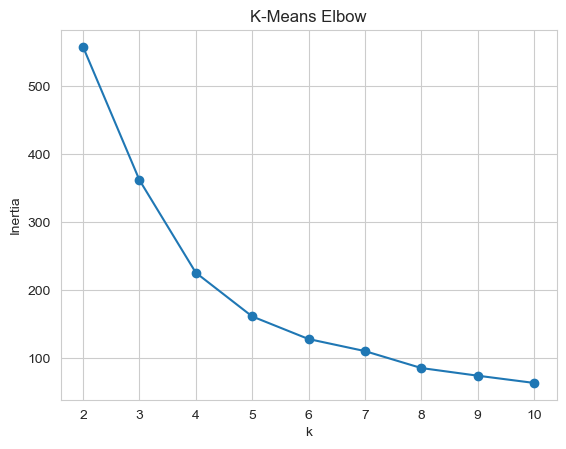

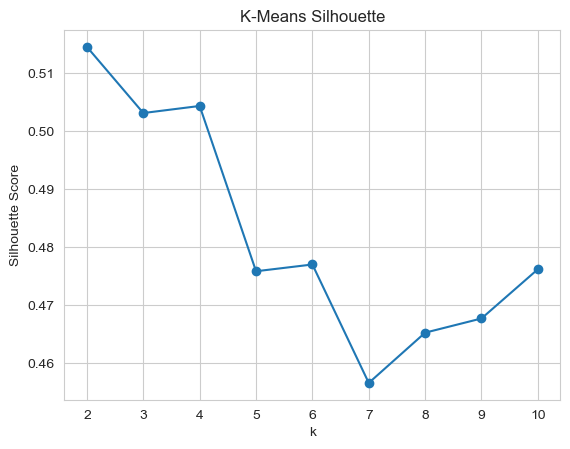

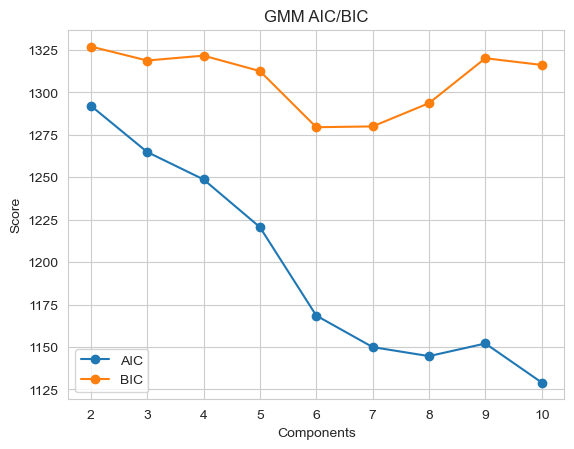

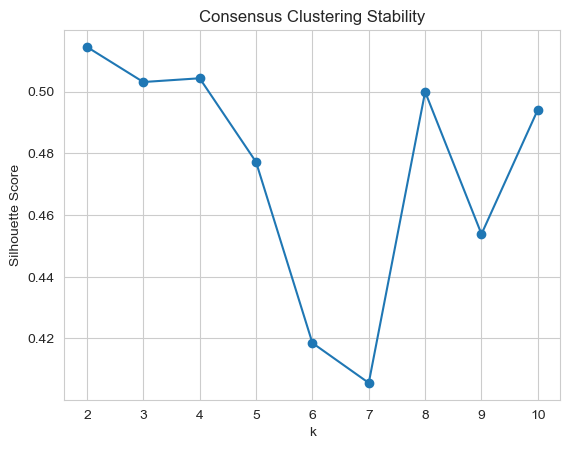



HDBSCAN found 11 clusters (excluding noise)



Clustering results...


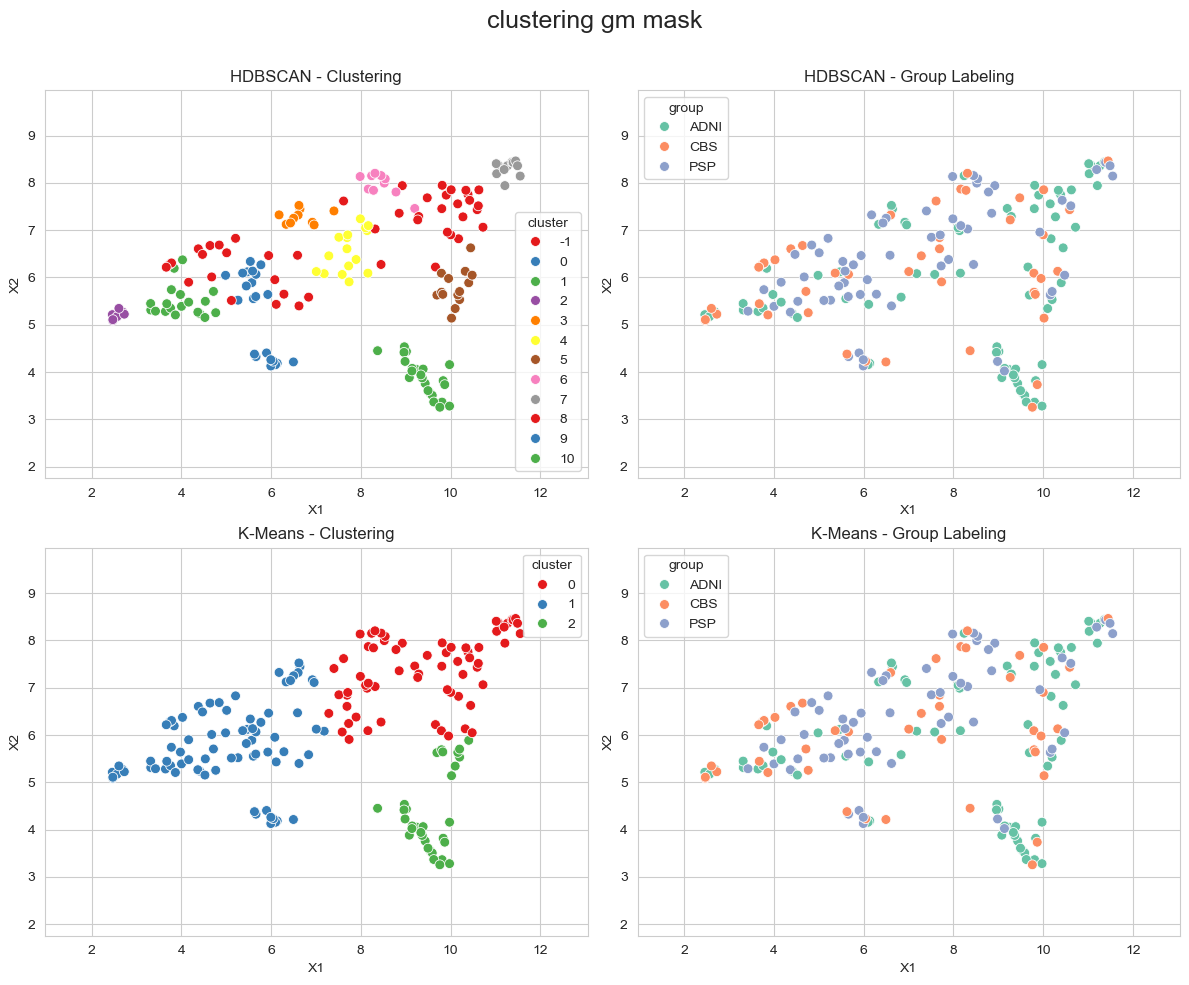

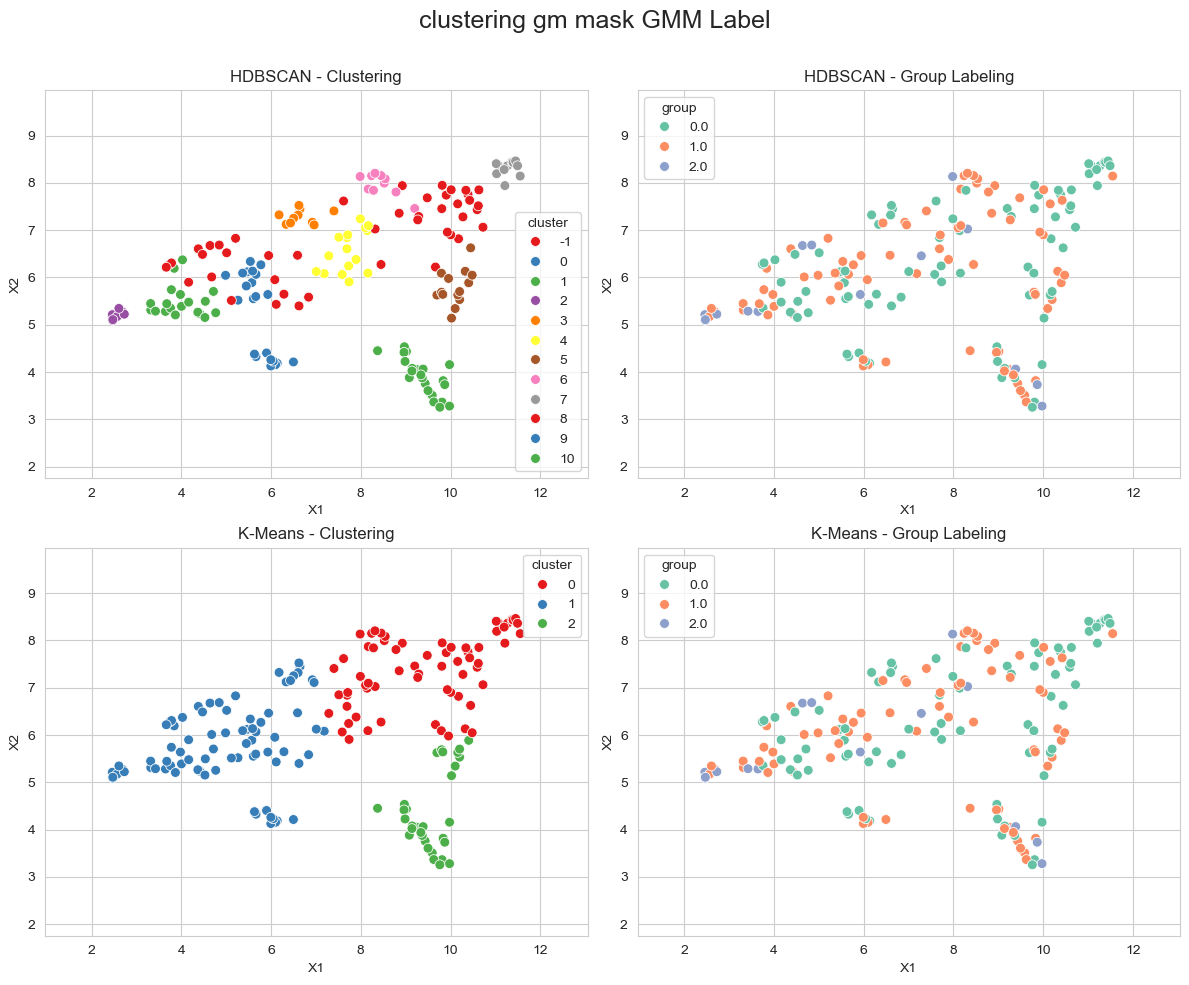

In [30]:
labeling, x_umap = main_clustering(df_gm_masked, df_meta,
                                   save_path = path_umap,
                                   title_umap = "umap_gm_mask",
                                   title_cluster = "clustering_gm_mask",
                                   plot_flag=plot_flag_cluster,
                                   do_eval=True,
                                   eval_save_path=path_opt_cluster)

Dataframe shape after merge: (176, 161825)
Meta columns: 8
Feature matrix shape: (176, 161817)


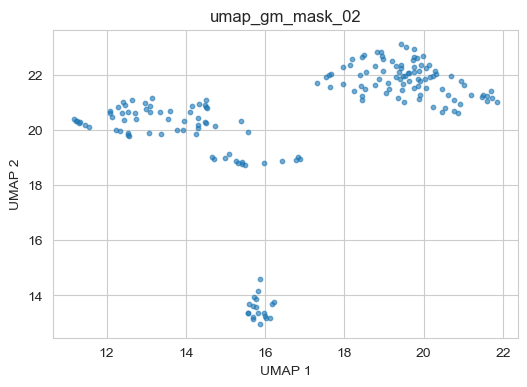


Evaluating clustering algorithms...


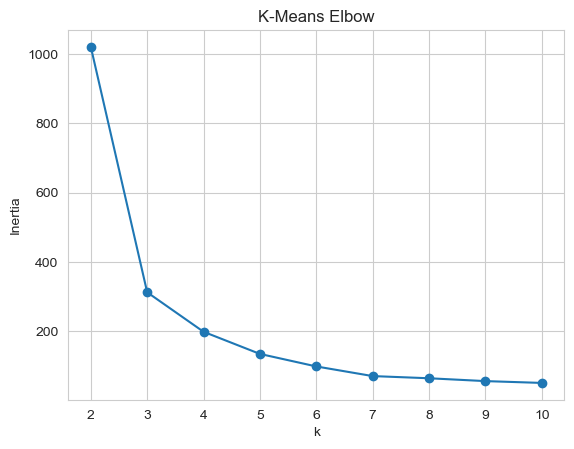

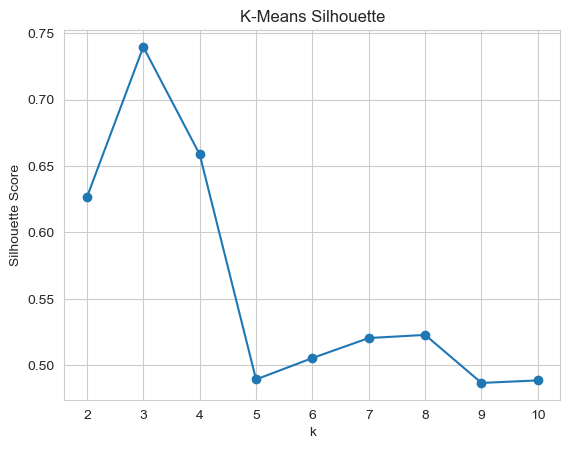

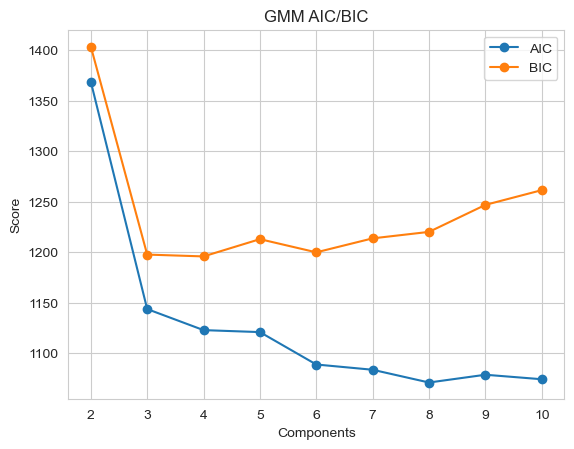

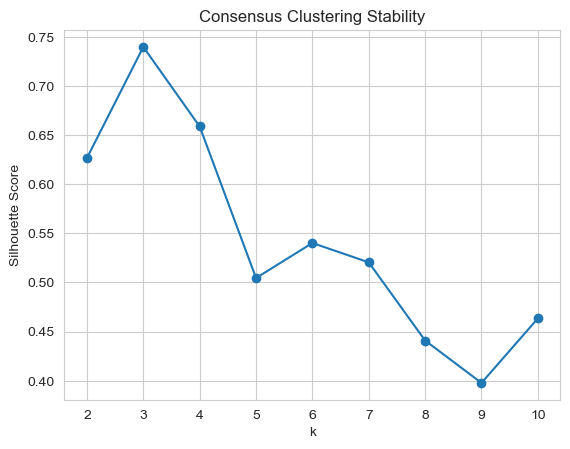



HDBSCAN found 5 clusters (excluding noise)



Clustering results...


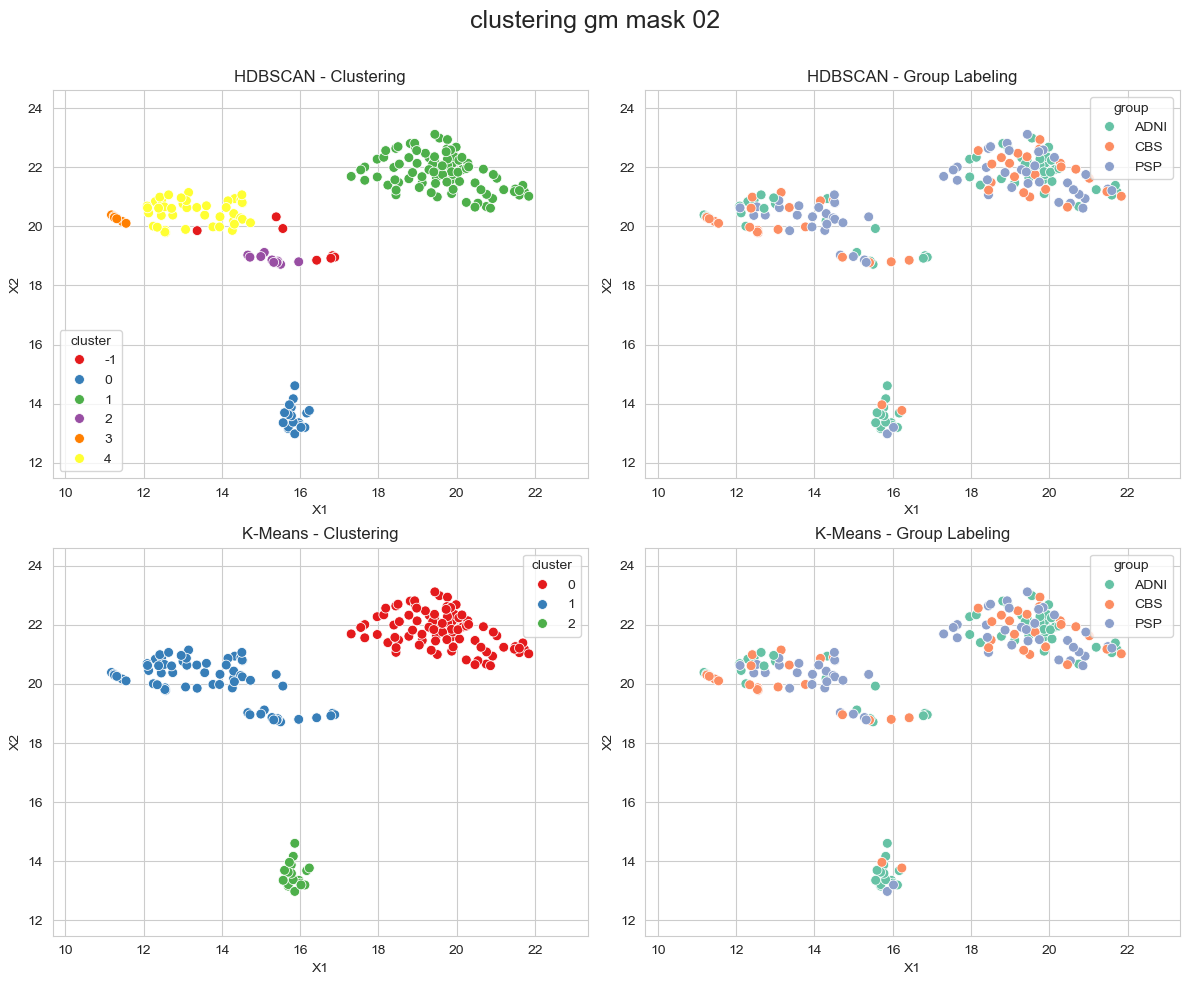

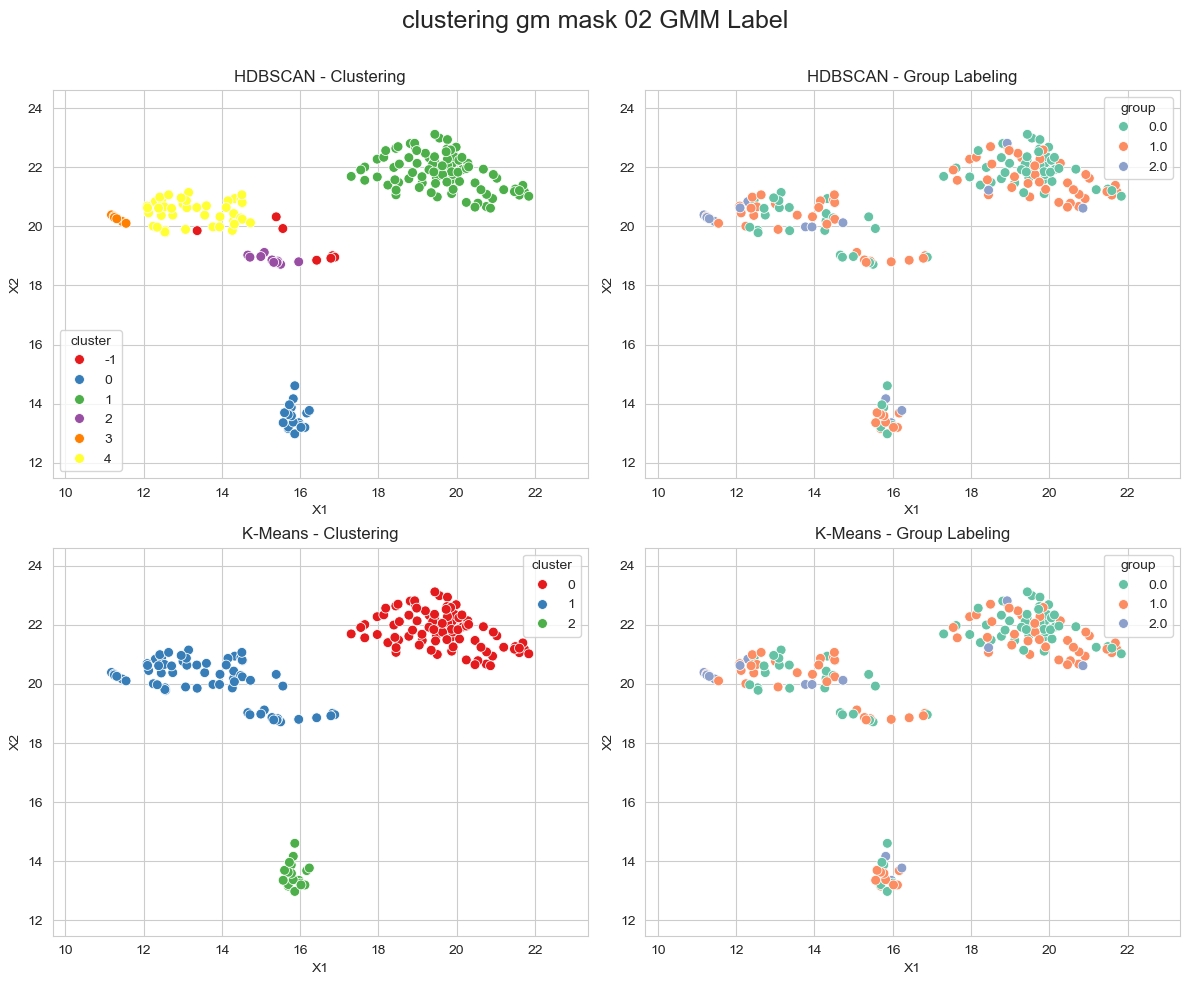

In [31]:
labeling, x_umap = main_clustering(df_thr02_gm_masked, df_meta,
                                   save_path = path_umap,
                                   title_umap = "umap_gm_mask_02",
                                   title_cluster= "clustering_gm_mask_02",
                                   plot_flag=plot_flag_cluster,
                                   do_eval=True,
                                   eval_save_path= path_opt_cluster)

Dataframe shape after merge: (176, 161825)
Meta columns: 8
Feature matrix shape: (176, 161817)


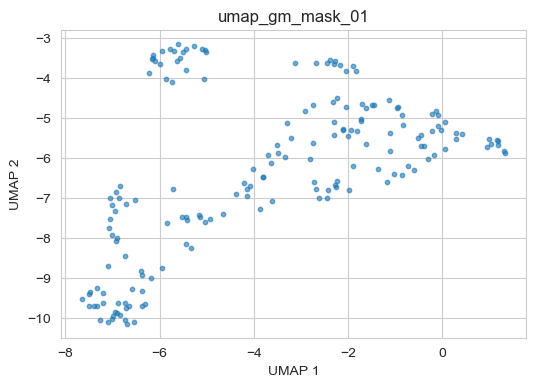


Evaluating clustering algorithms...


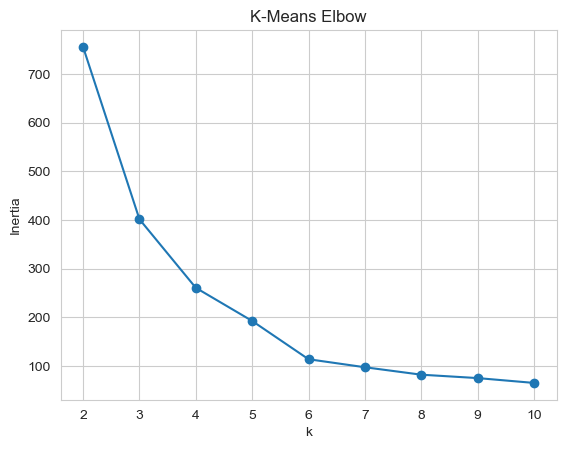

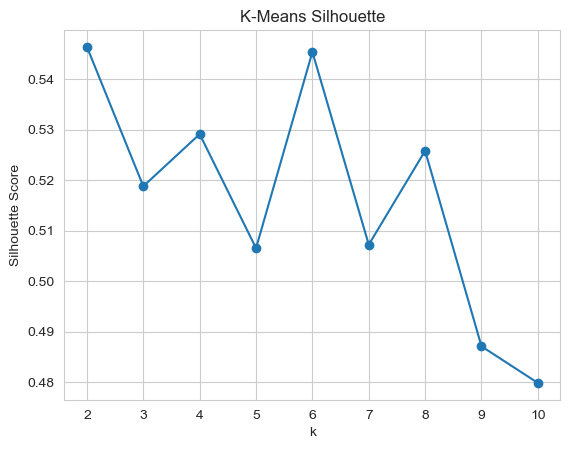

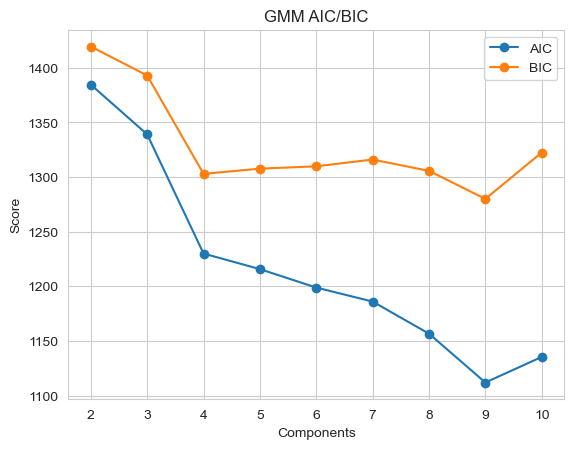

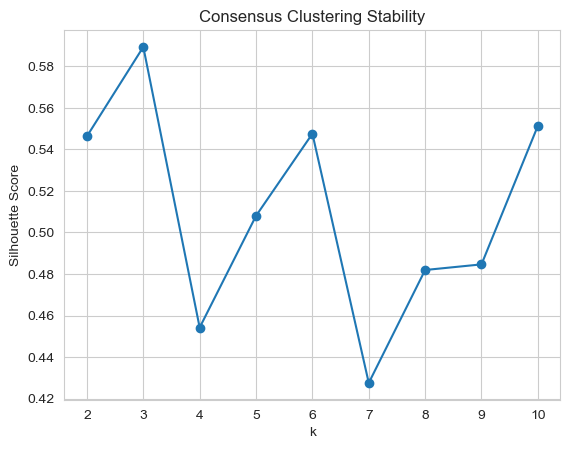



HDBSCAN found 2 clusters (excluding noise)



Clustering results...


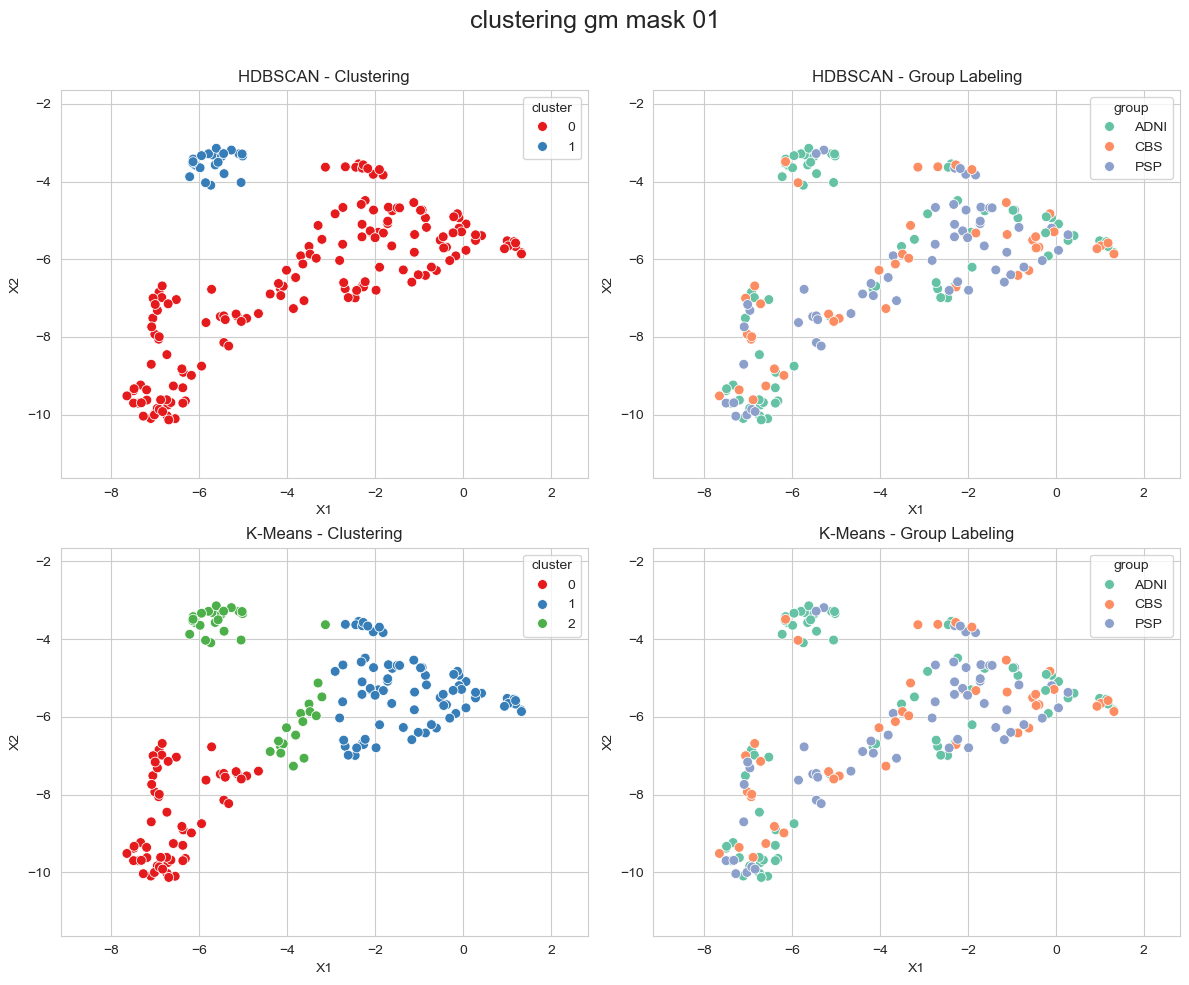

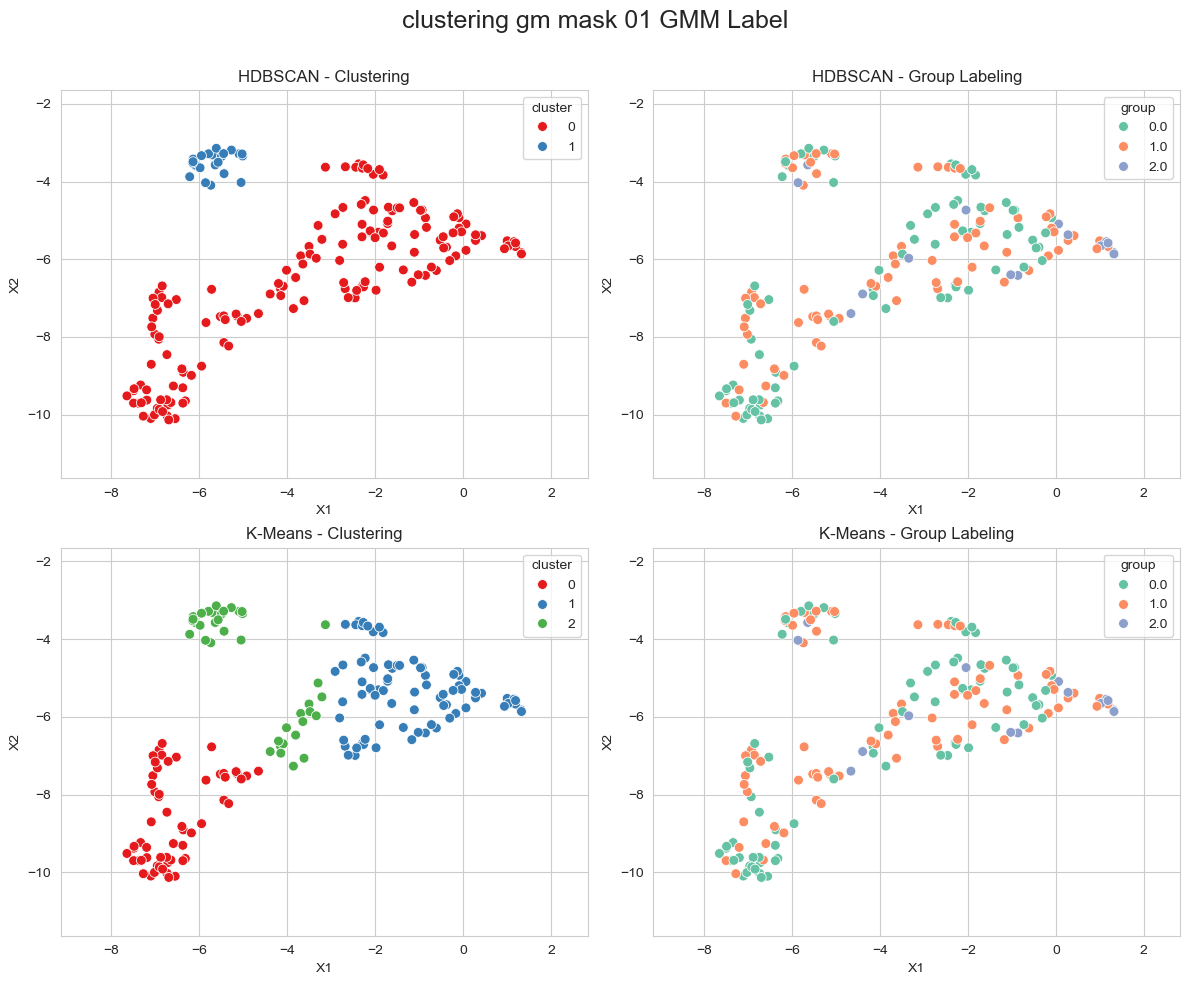

In [32]:
labeling, x_umap = main_clustering(df_thr01_gm_masked, df_meta,
                                   save_path = path_umap,
                                   title_umap = "umap_gm_mask_01",
                                   title_cluster = "clustering_gm_mask_01",
                                   plot_flag=plot_flag_cluster,
                                   do_eval=True,
                                   eval_save_path=path_opt_cluster)

Dataframe shape after merge: (176, 55012)
Meta columns: 8
Feature matrix shape: (176, 55004)


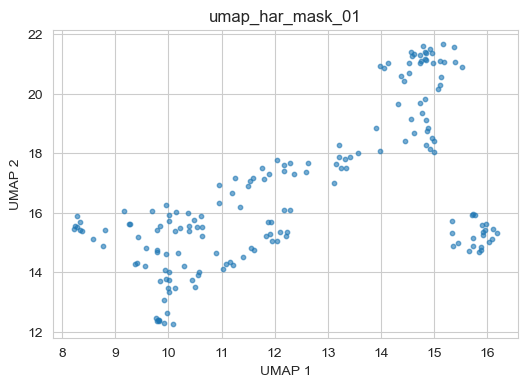


Evaluating clustering algorithms...


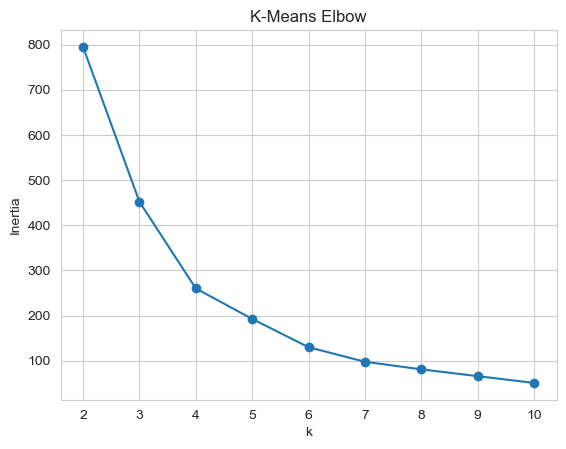

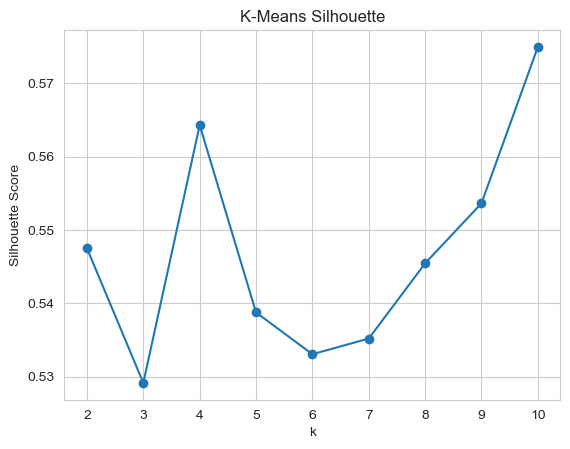

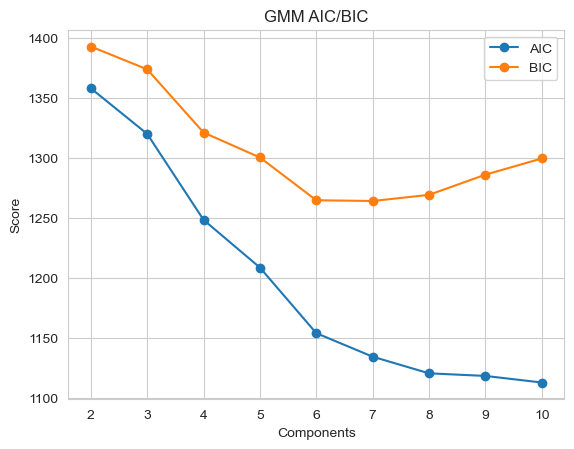

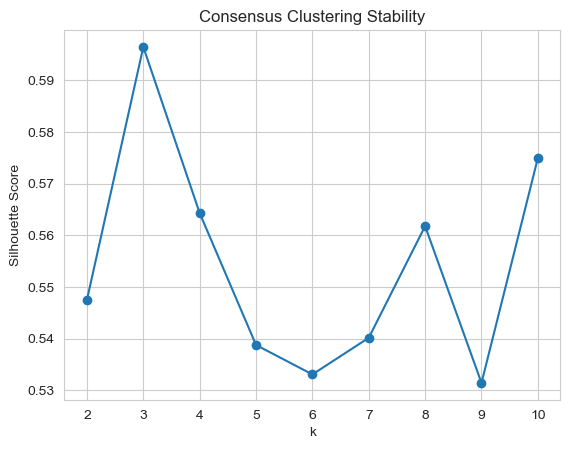



HDBSCAN found 10 clusters (excluding noise)



Clustering results...


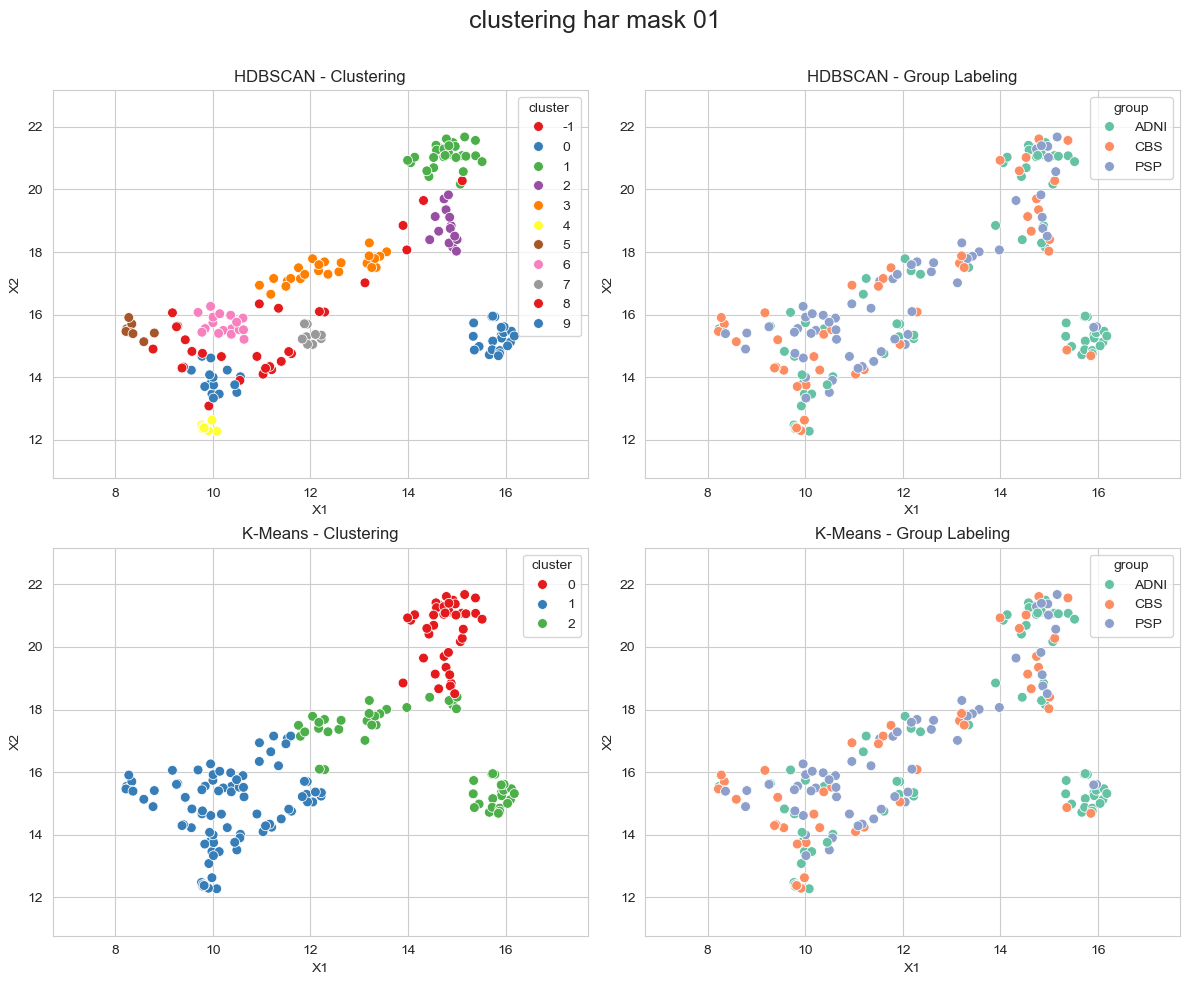

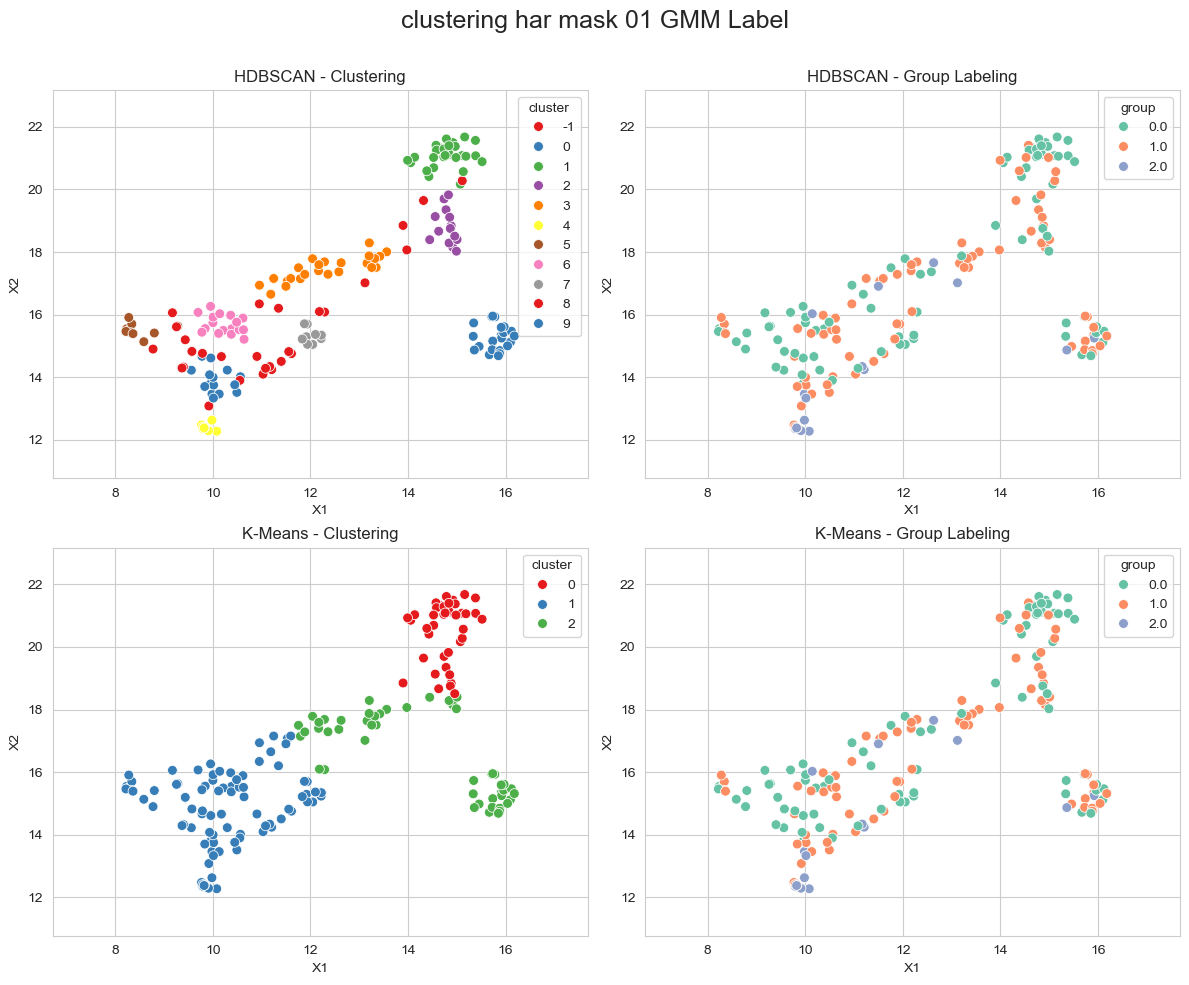

In [33]:
labeling, x_umap = main_clustering(df_thr01_har_masked, df_meta,
                                   save_path = path_umap,
                                   title_umap = "umap_har_mask_01",
                                   title_cluster = "clustering_har_mask_01",
                                   plot_flag=plot_flag_cluster,
                                   do_eval=True,
                                   eval_save_path=path_opt_cluster)

Dataframe shape after merge: (176, 55012)
Meta columns: 8
Feature matrix shape: (176, 55004)


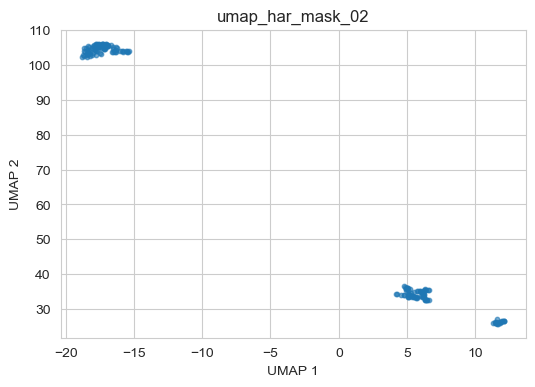


Evaluating clustering algorithms...


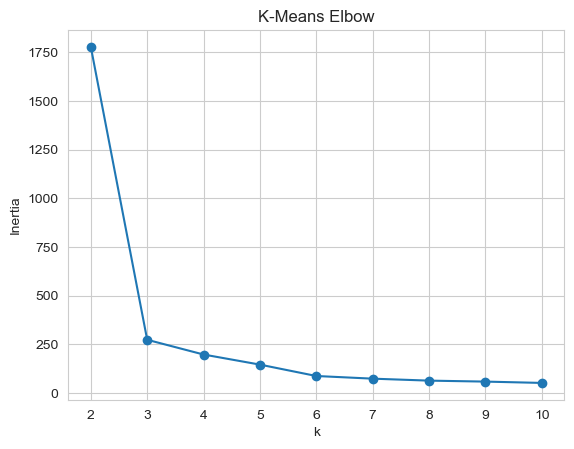

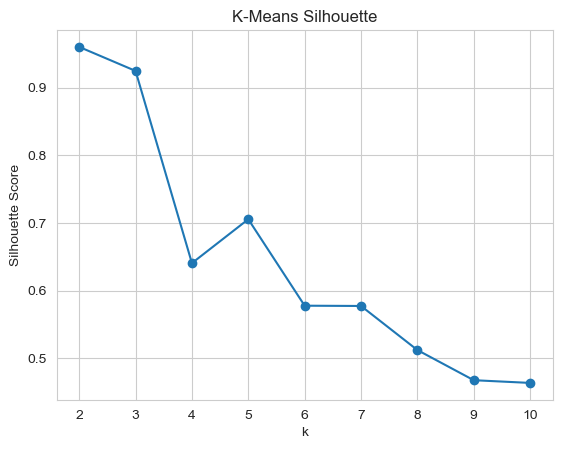

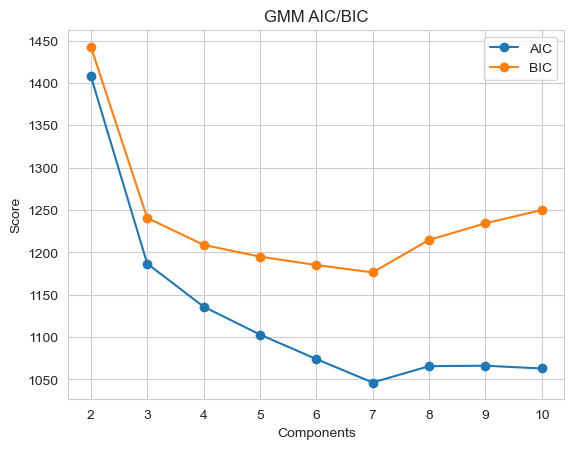

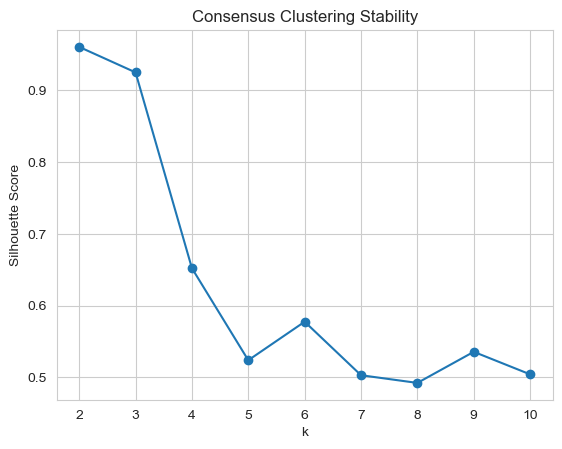



HDBSCAN found 3 clusters (excluding noise)



Clustering results...


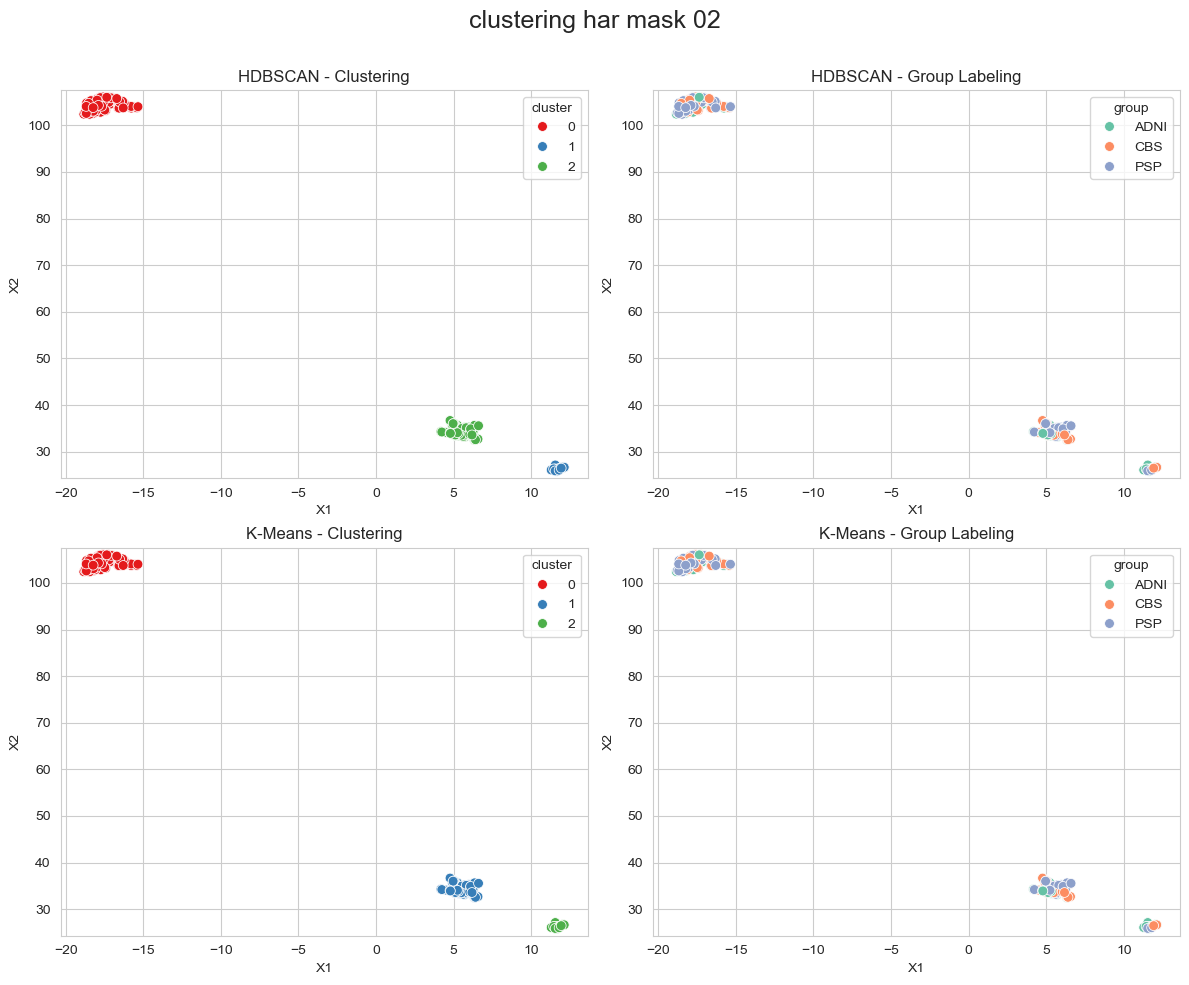

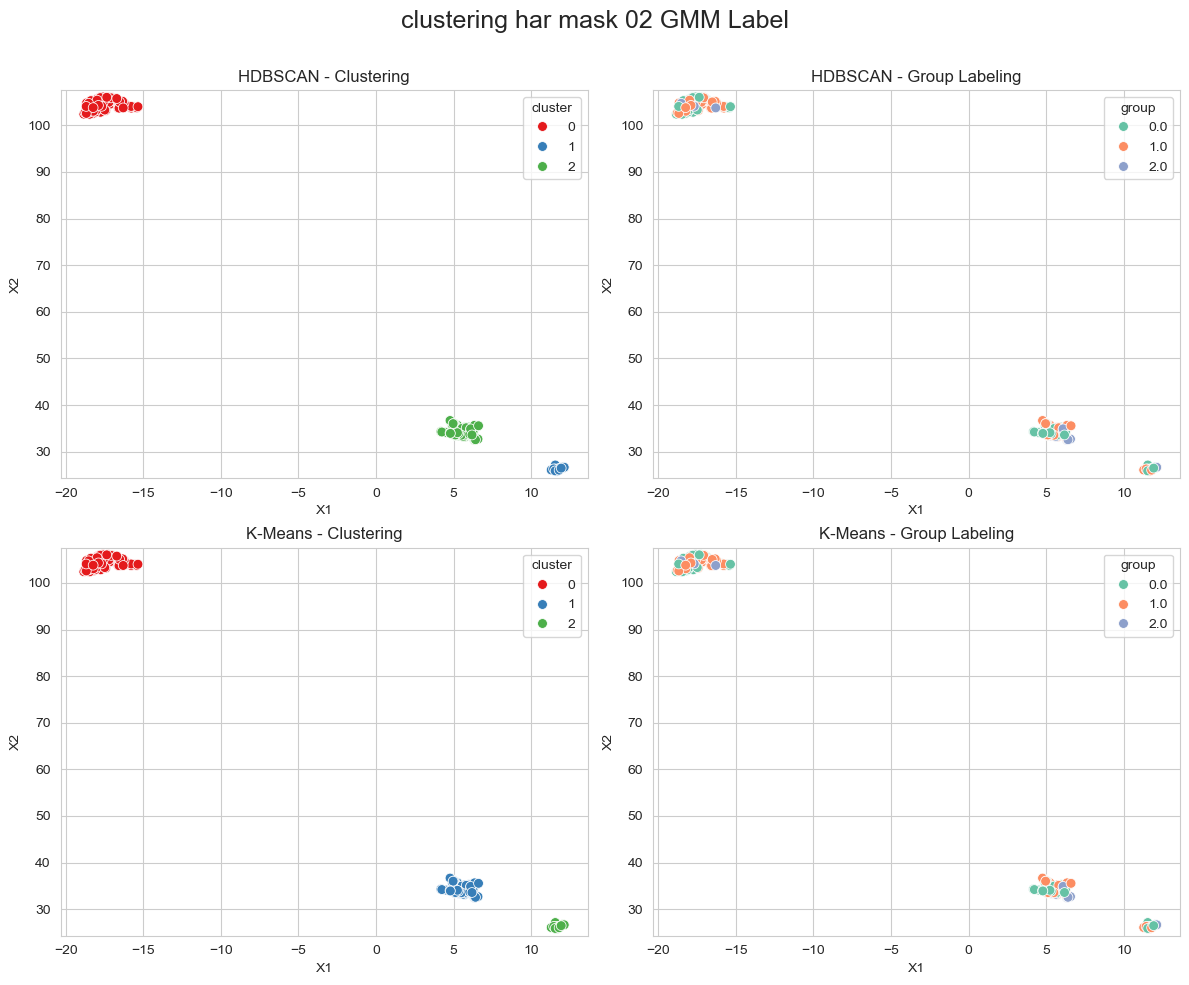

In [34]:
labeling, x_umap = main_clustering(df_thr02_har_masked, df_meta,
                                   save_path = path_umap,
                                   title_umap = "umap_har_mask_02",
                                   title_cluster = "clustering_har_mask_02",
                                   plot_flag=plot_flag_cluster,
                                   do_eval=True,
                                   eval_save_path=path_opt_cluster)

Dataframe shape after merge: (176, 55012)
Meta columns: 8
Feature matrix shape: (176, 55004)


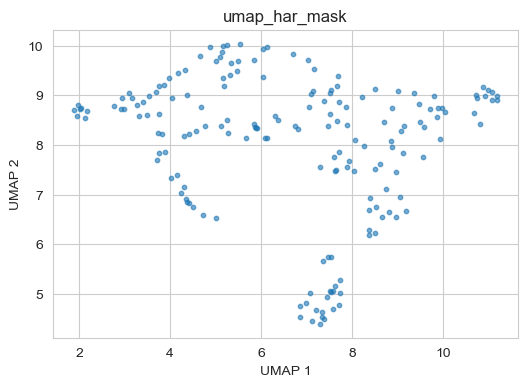


Evaluating clustering algorithms...


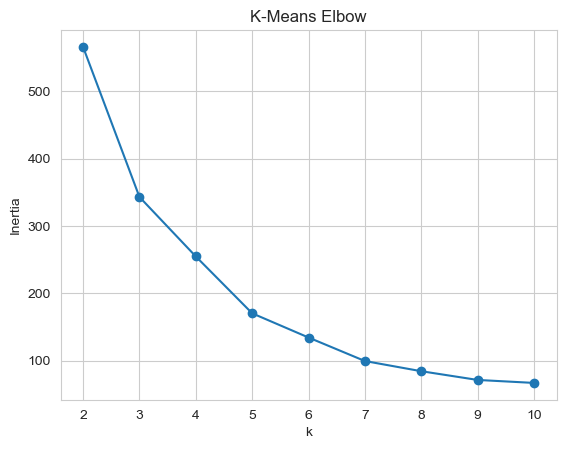

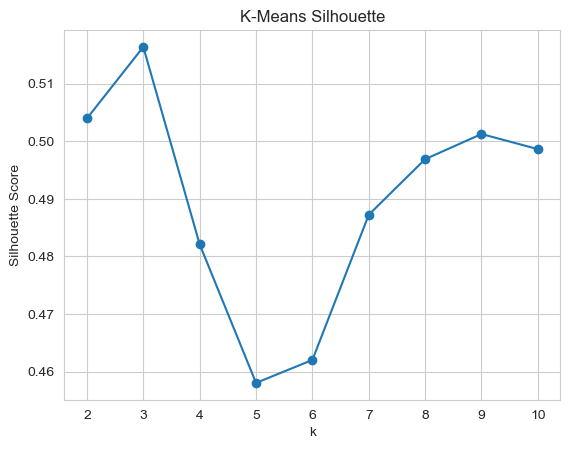

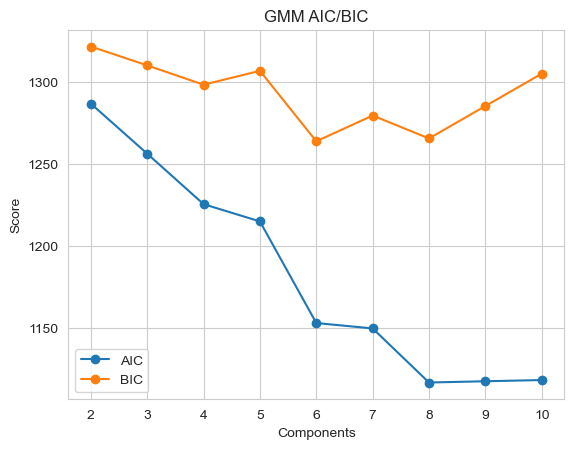

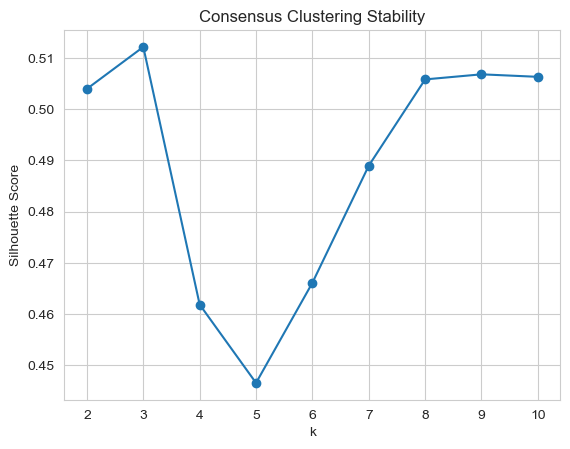



HDBSCAN found 11 clusters (excluding noise)



Clustering results...


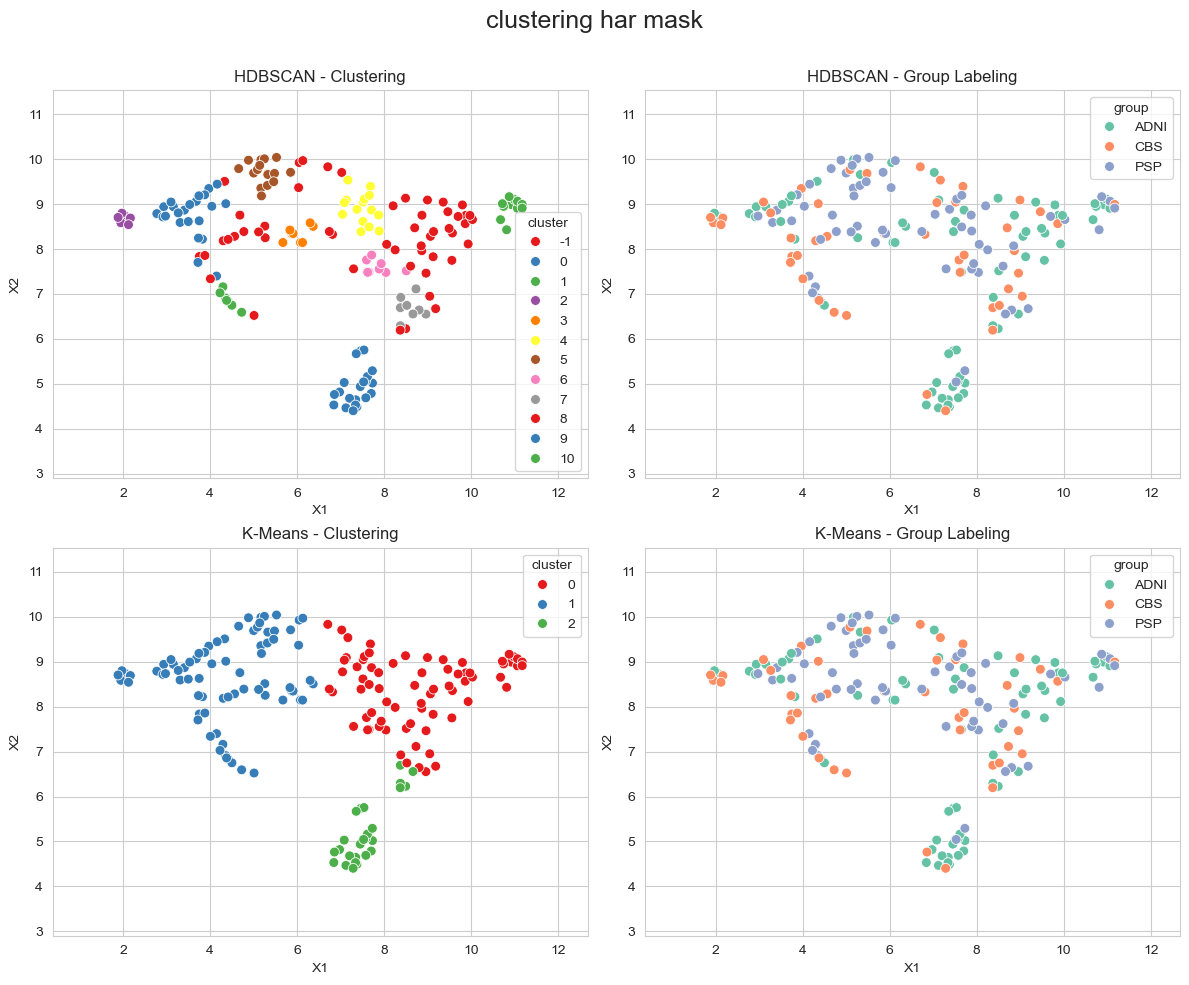

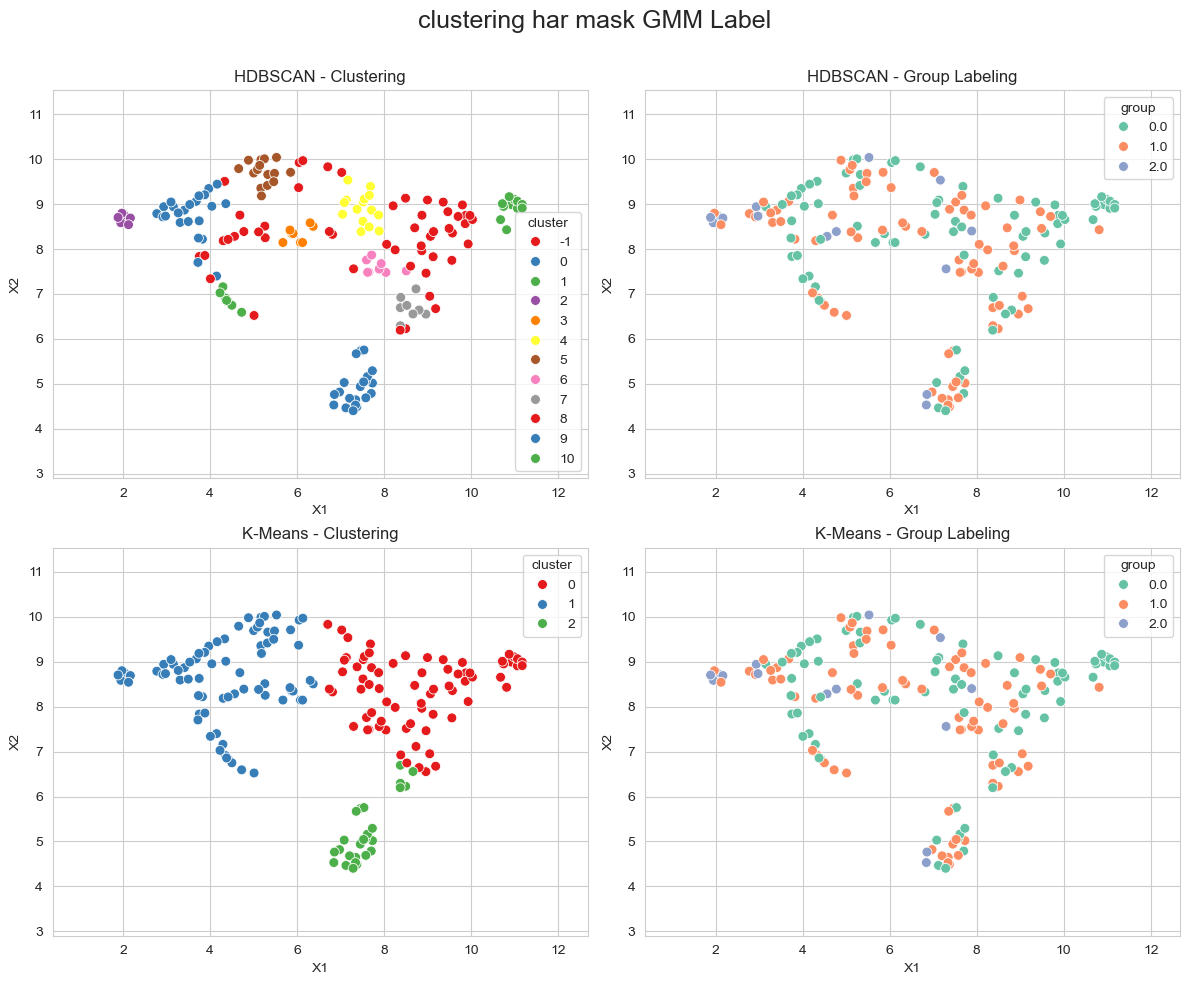

In [35]:
labeling, x_umap = main_clustering(df_har_masked, df_meta,
                                   save_path = path_umap,
                                   title_umap = "umap_har_mask",
                                   title_cluster = "clustering_har_mask",
                                   plot_flag=plot_flag_cluster,
                                   do_eval=True,
                                   eval_save_path=None)

### Yeo Networks

In [60]:
path_network_cluster = "/Users/emmatosato/Documents/PhD/ANM_Verona/output/umap_network_cluster"

Dataframe shape after merge: (176, 16)
Meta columns: 8
Feature matrix shape: (176, 8) 



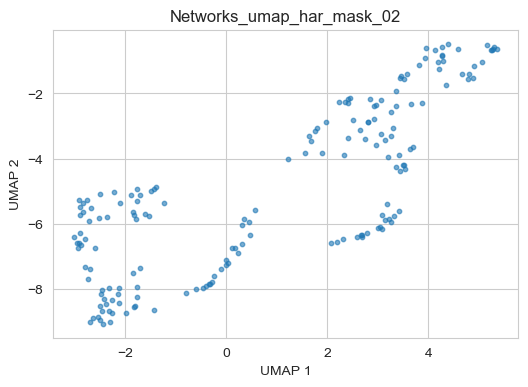


Evaluating clustering algorithms...


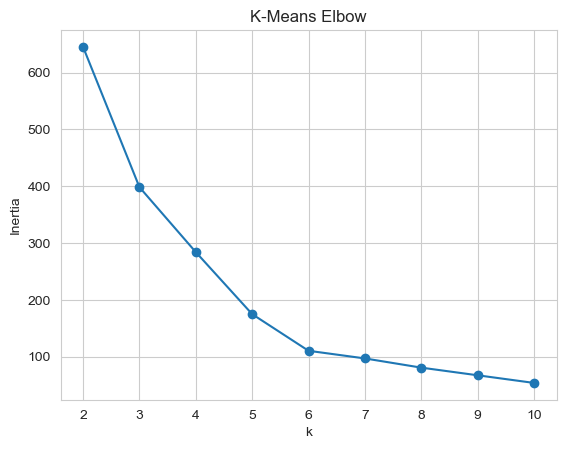

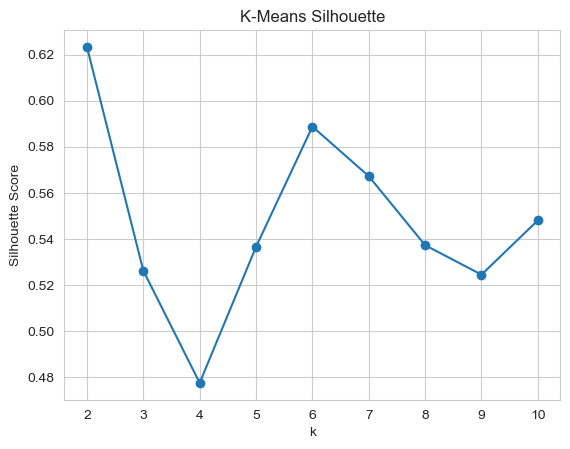

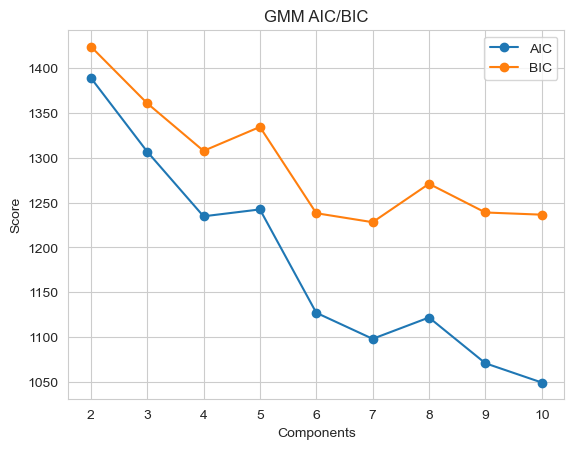

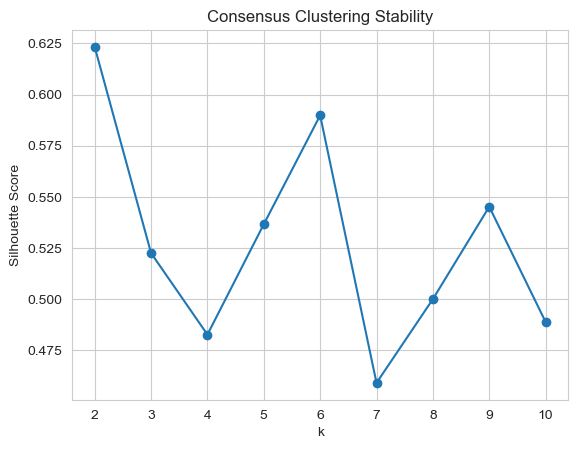



HDBSCAN found 5 clusters (excluding noise)



Clustering results...


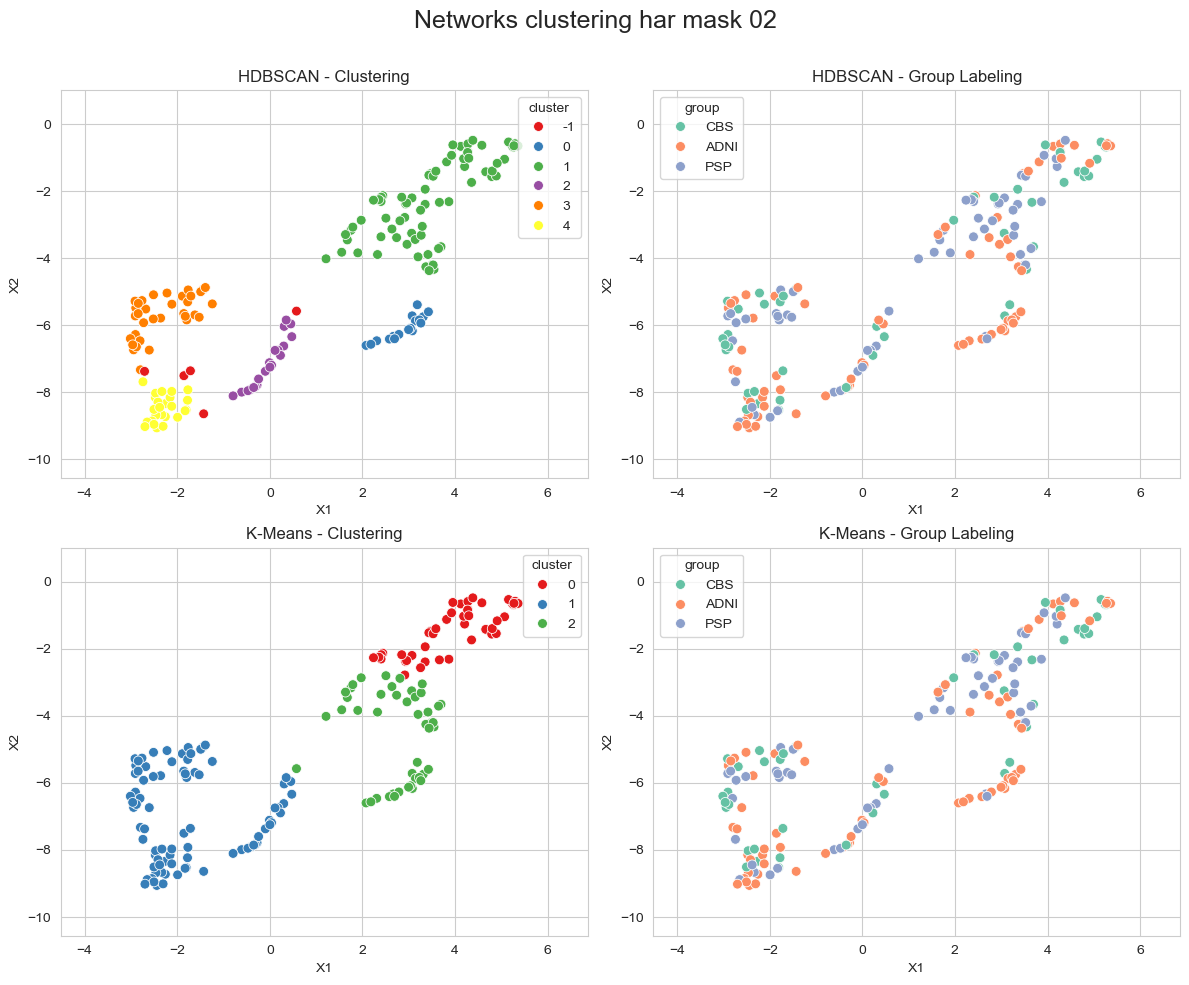

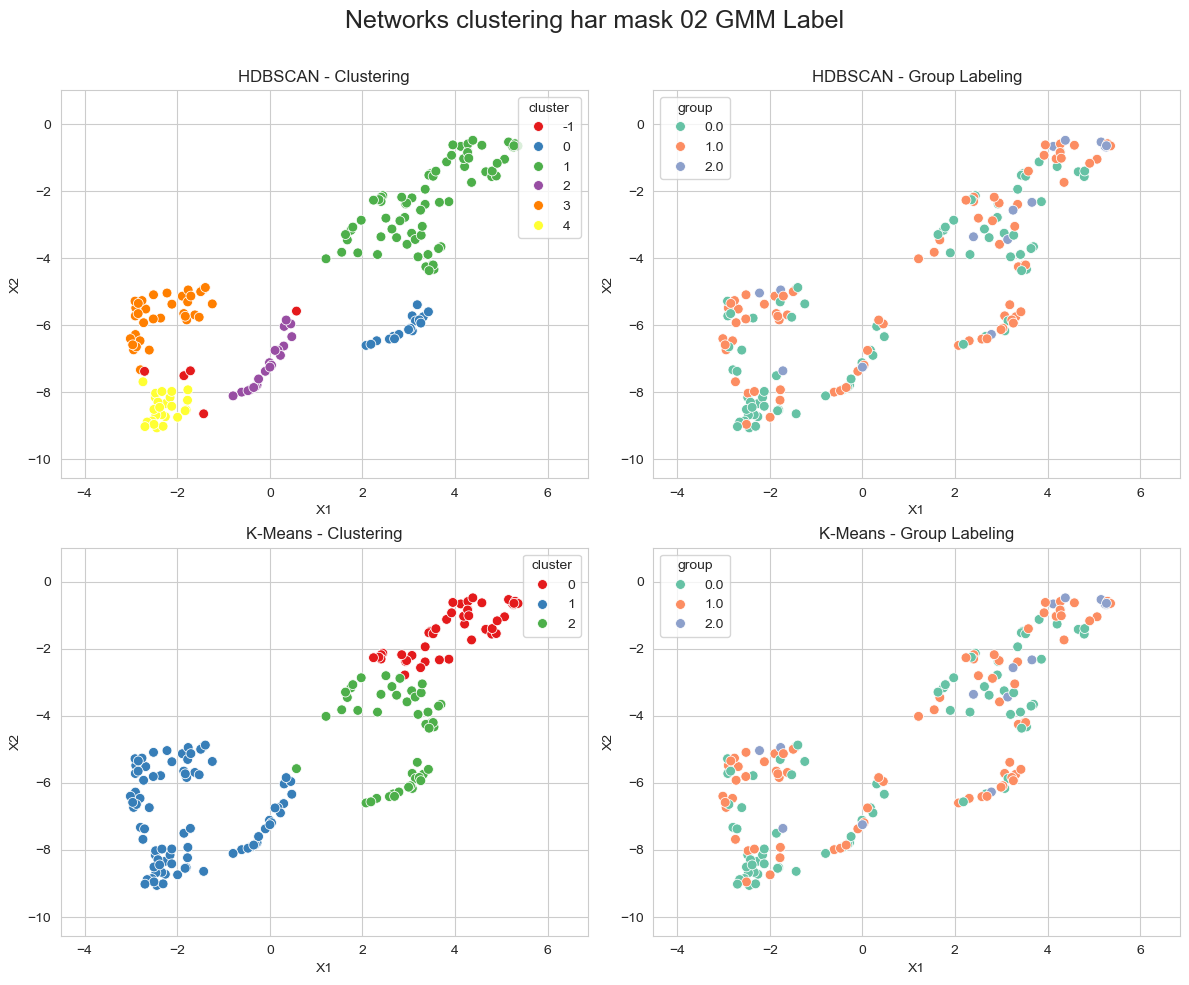

In [61]:
labeling, x_umap = main_clustering(df_networks_thr02, df_meta,
                                   save_path = path_network_cluster,
                                   title_umap = "Networks_umap_har_mask_02",
                                   title_cluster = "Networks_clustering_har_mask_02",
                                   plot_flag=plot_flag_cluster,
                                   do_eval=True,
                                   eval_save_path=None)

Dataframe shape after merge: (176, 16)
Meta columns: 8
Feature matrix shape: (176, 8) 



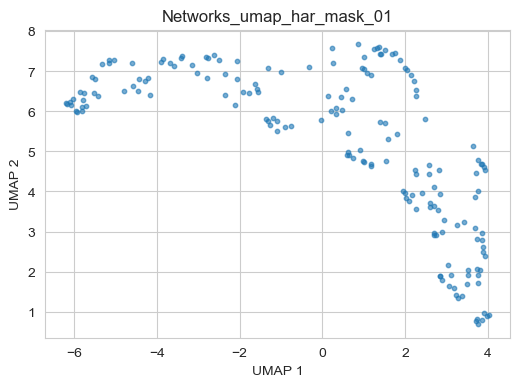


Evaluating clustering algorithms...


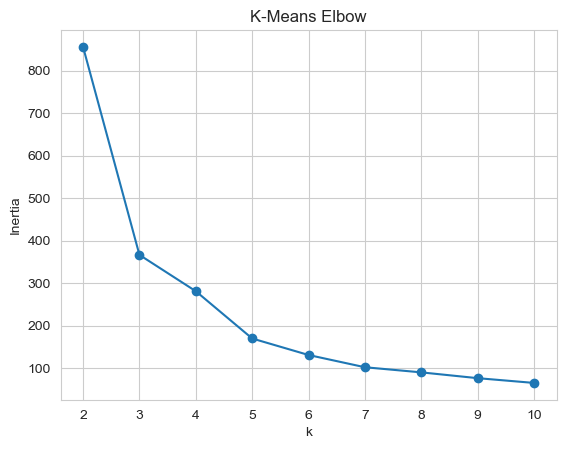

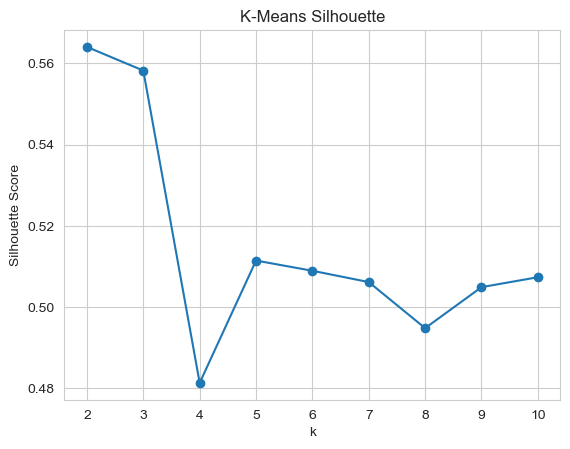

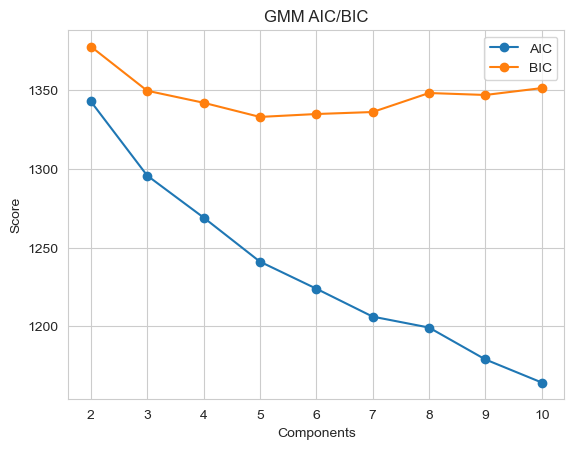

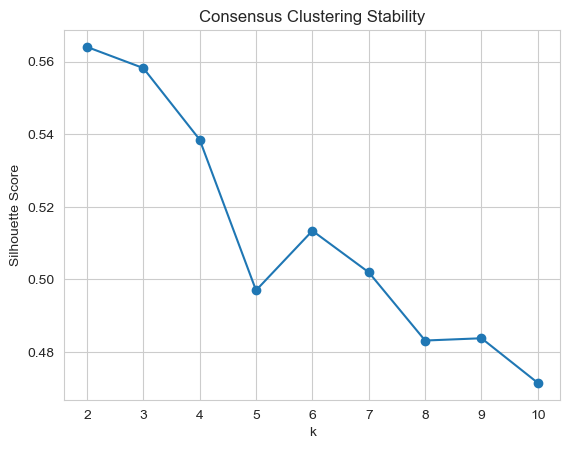



HDBSCAN found 10 clusters (excluding noise)



Clustering results...


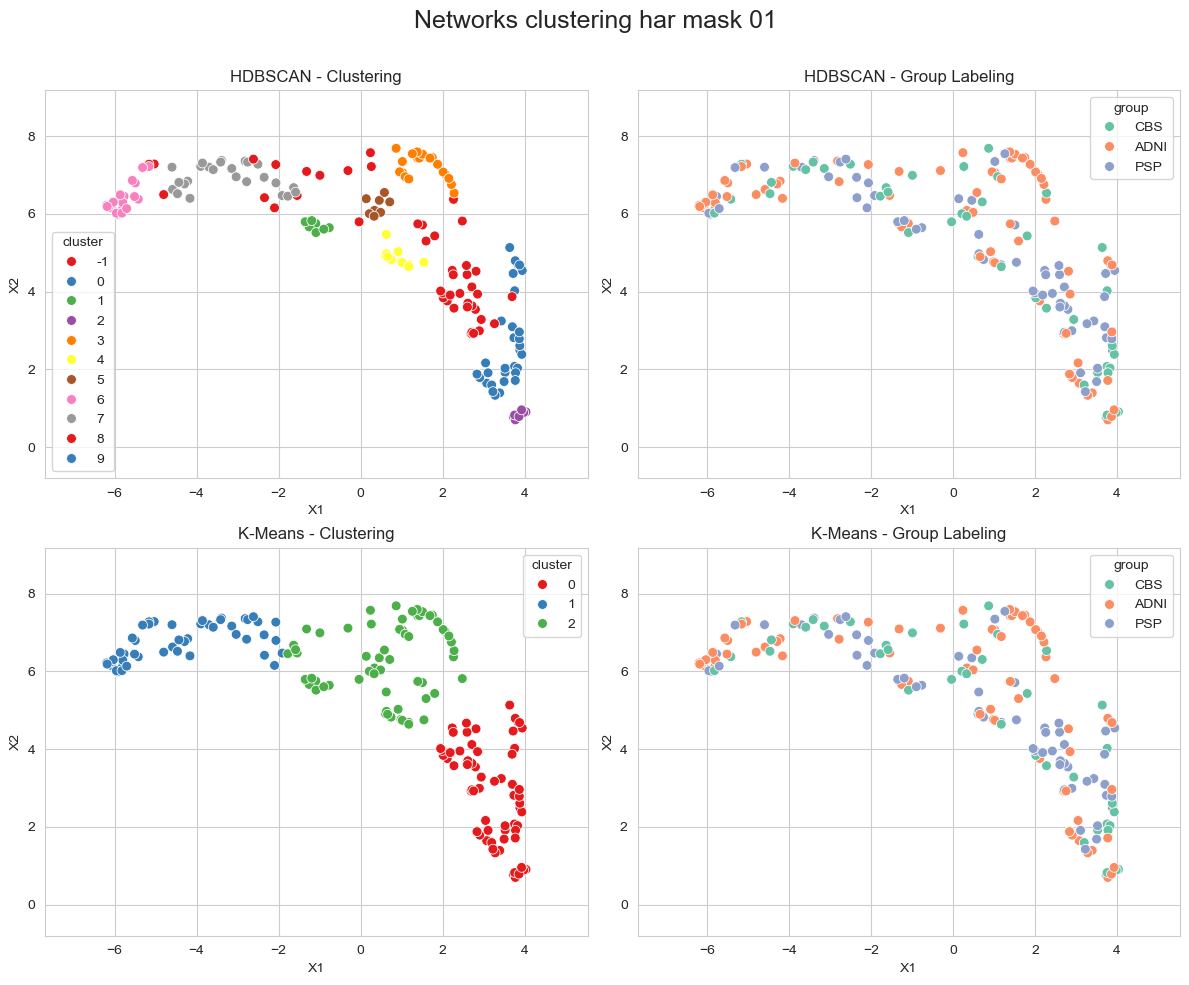

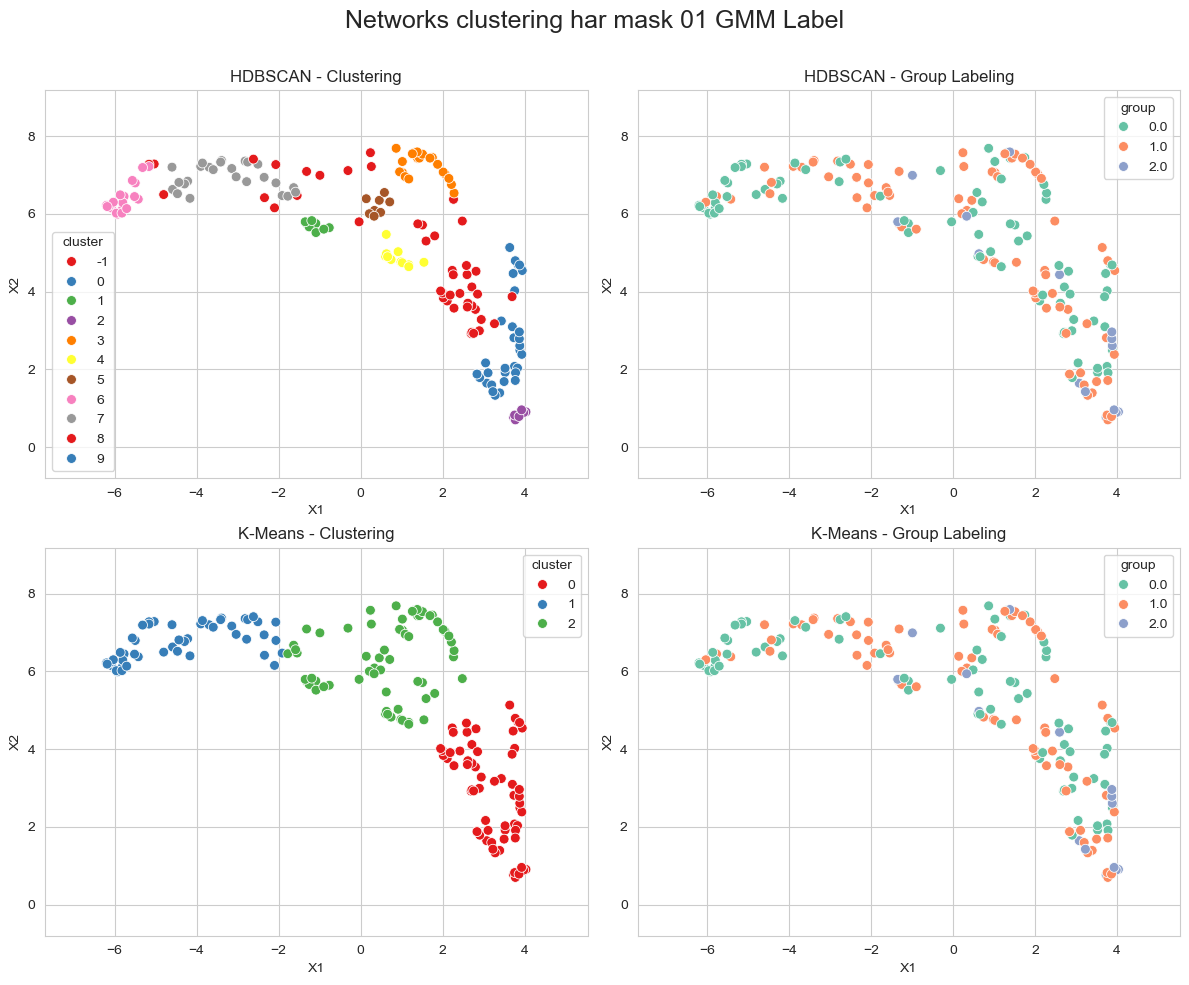

In [62]:
labeling, x_umap = main_clustering(df_networks_thr01, df_meta,
                                   save_path = path_network_cluster,
                                   title_umap = "Networks_umap_har_mask_01",
                                   title_cluster = "Networks_clustering_har_mask_01",
                                   plot_flag=plot_flag_cluster,
                                   do_eval=True,
                                   eval_save_path=None)

Dataframe shape after merge: (176, 16)
Meta columns: 8
Feature matrix shape: (176, 8) 



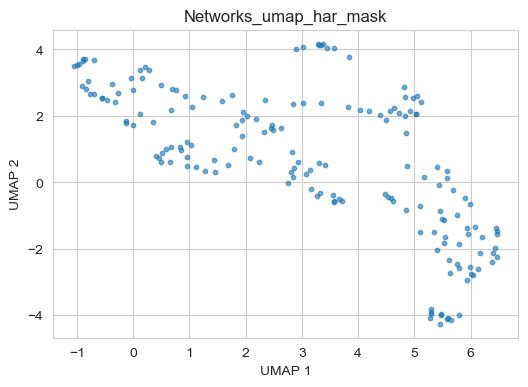


Evaluating clustering algorithms...


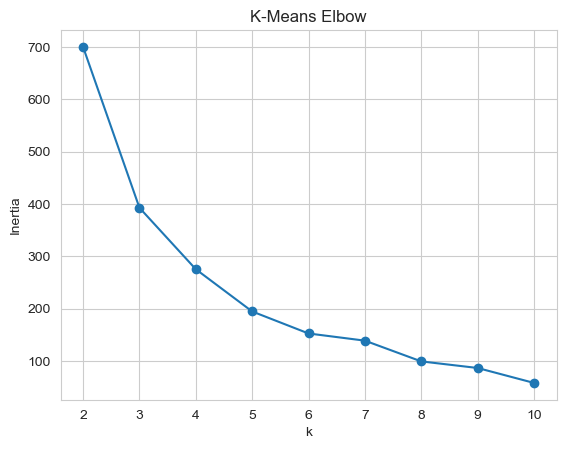

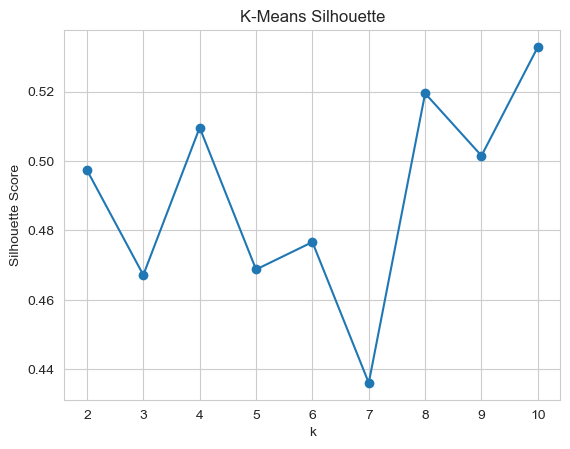

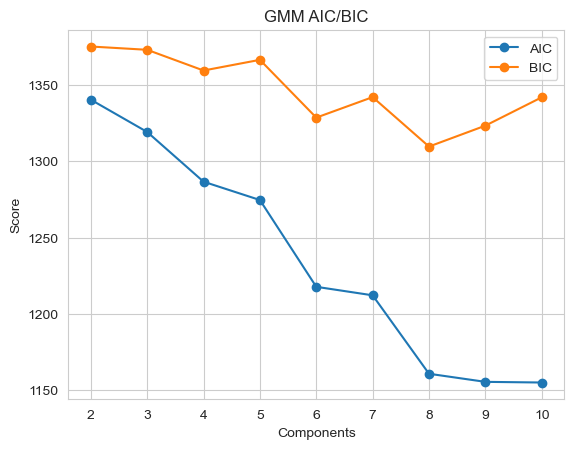

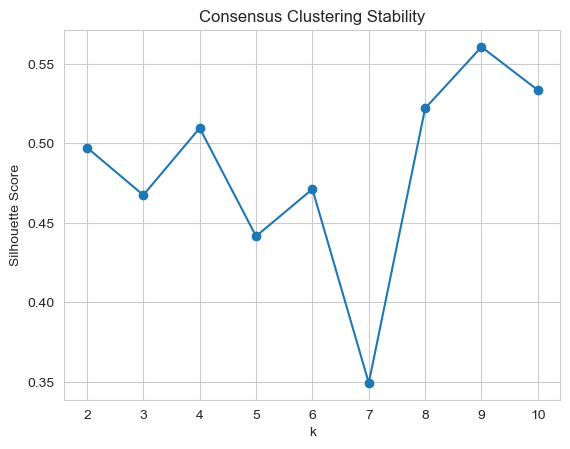



HDBSCAN found 10 clusters (excluding noise)



Clustering results...


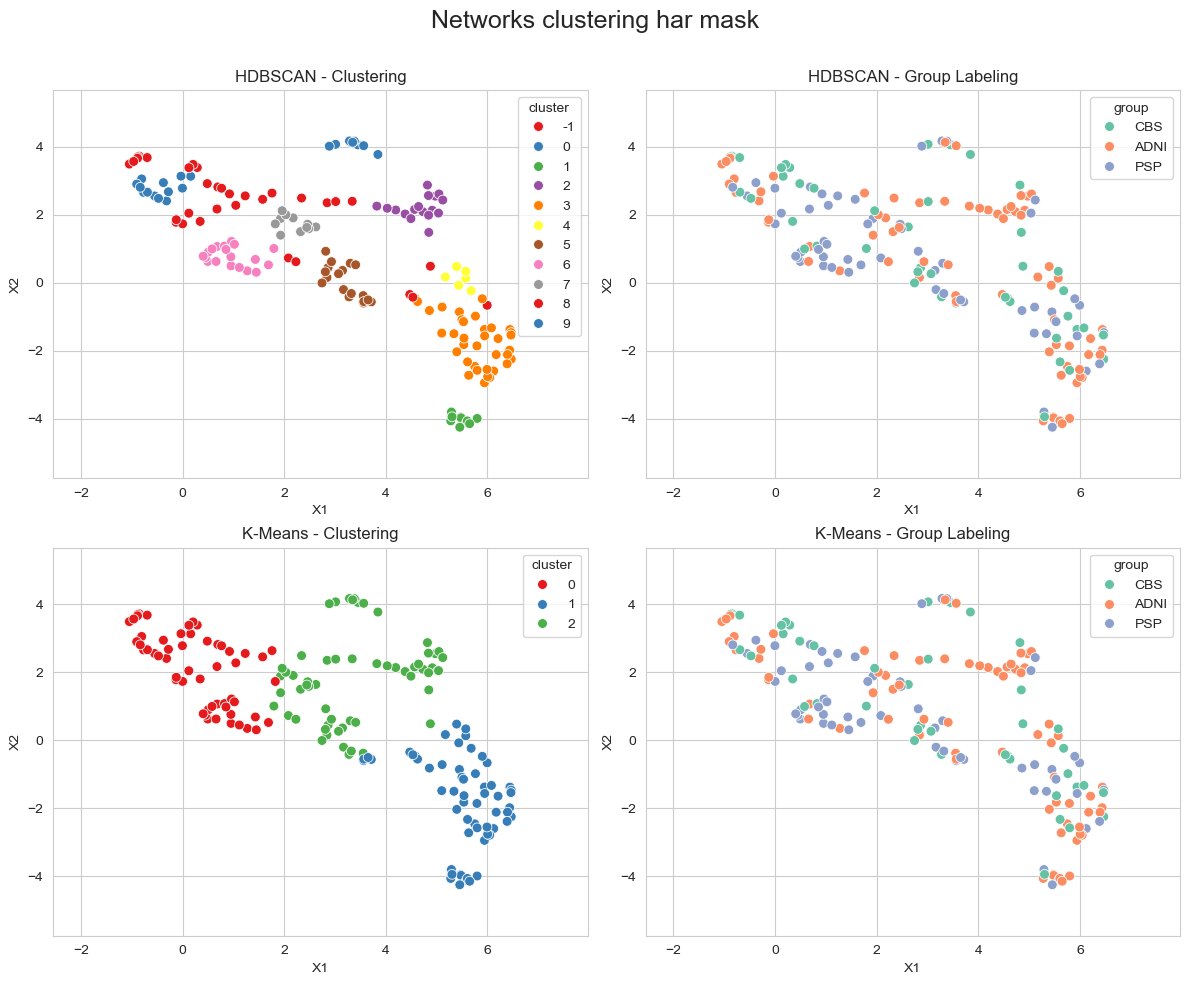

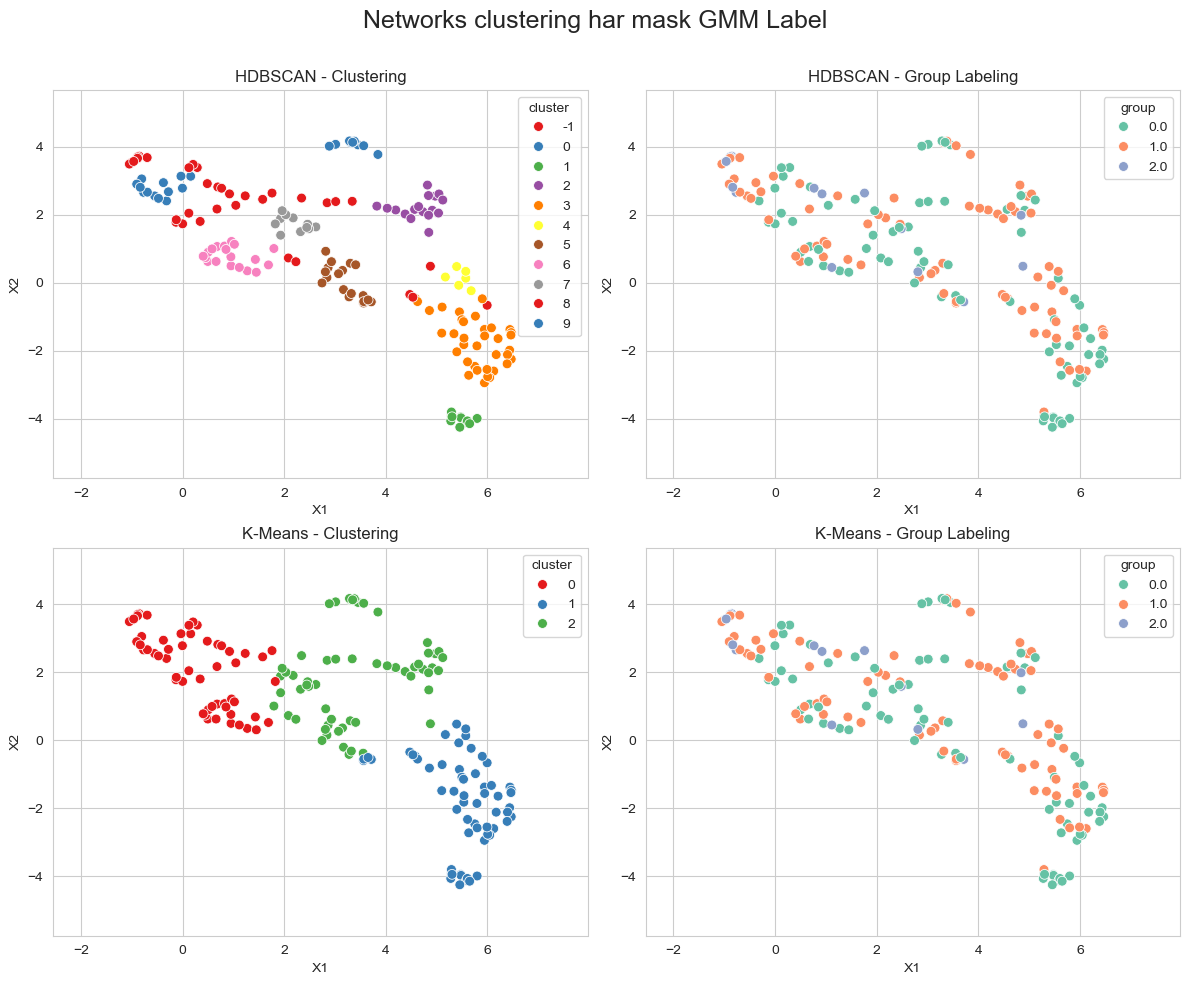

In [63]:
labeling, x_umap = main_clustering(df_networks_no_thr, df_meta,
                                   save_path = path_network_cluster,
                                   title_umap = "Networks_umap_har_mask",
                                   title_cluster = "Networks_clustering_har_mask",
                                   plot_flag=plot_flag_cluster,
                                   do_eval=True,
                                   eval_save_path=None)

## Linear Regression

- About the input
    - DataFrame that have been processed
    - The metadata
    - Target variable that we’ll be regressed
    - Covariates
    - Possibility to log transform the target
    - Possibility to plot ==> save the plot in a different directory if you change the target variable
    - Possibility to save the plot
    - Prefix for title and path
- Again the subjects witout the target are removed
- UMAP for dimensionality reduction
- Fit OLS model
- Shuffling regression
- Results are printed


In [48]:
path_umap_regression = '/Users/emmatosato/Documents/PhD/ANM_Verona/output/umap_regression_CDR_SB'
target_col = "CDR_SB"
plot_flag_regression = True

### CDR sum of boxes

#### Voxel

##### GM Mask

Dataframe shape after merge: (171, 161825)
Meta columns: 8
Feature matrix shape: (171, 161817) 



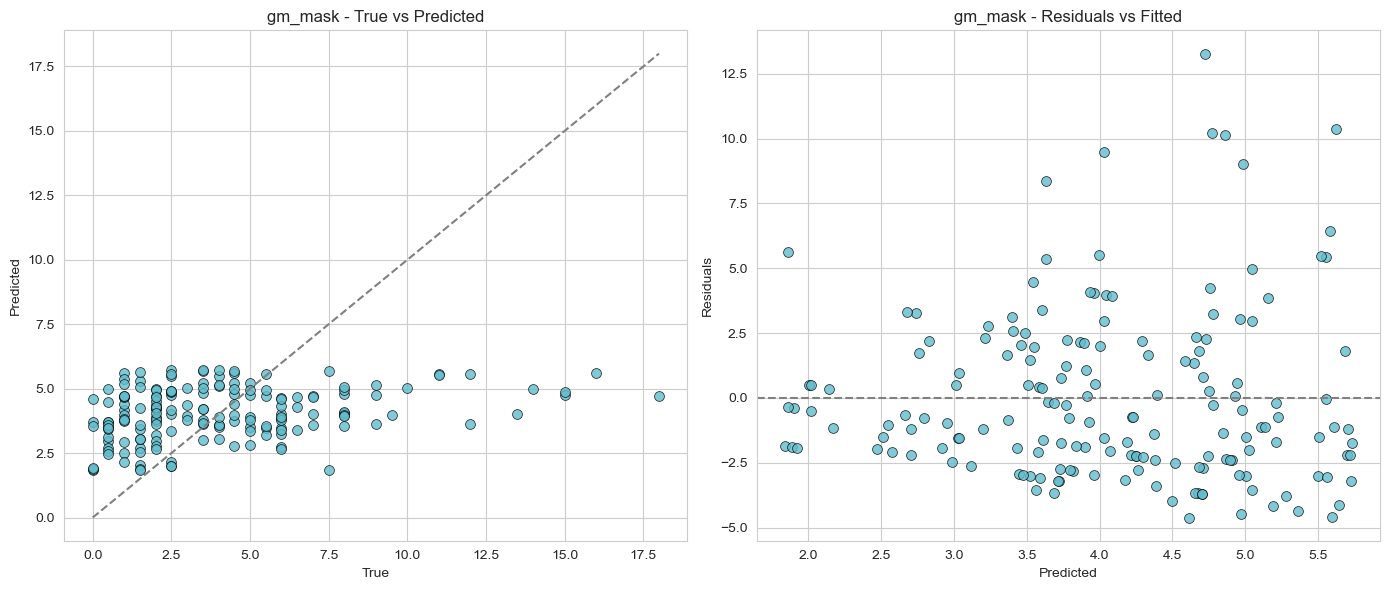

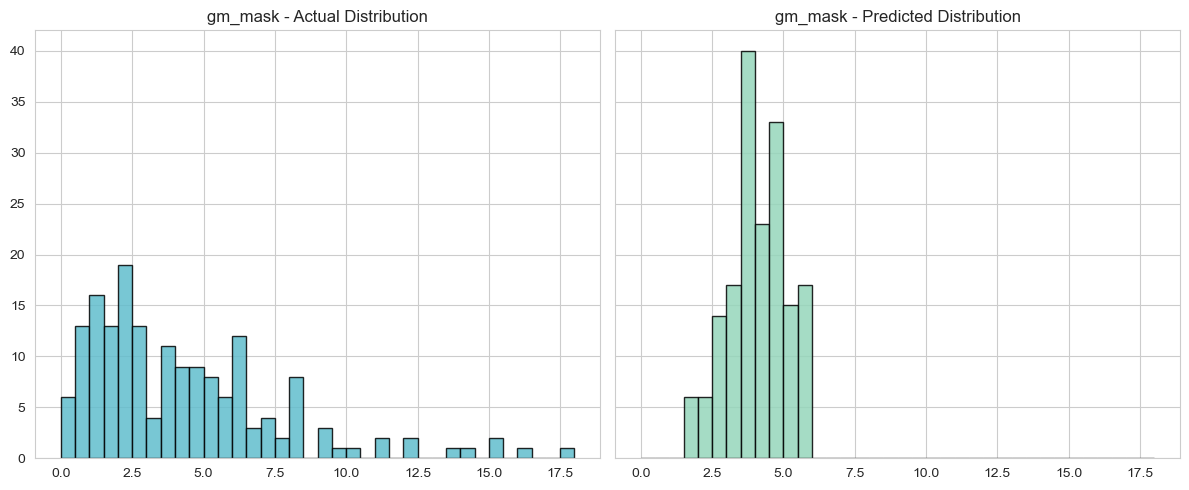

                            OLS Regression Results                            
Dep. Variable:                 CDR_SB   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     7.707
Date:                Thu, 29 May 2025   Prob (F-statistic):           0.000628
Time:                        18:48:53   Log-Likelihood:                -445.84
No. Observations:                 171   AIC:                             897.7
Df Residuals:                     168   BIC:                             907.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.5135      1.161      7.332      0.0

In [46]:
model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
    df_masked = df_gm_masked,
    df_meta = df_meta,
    target_variable = target_col,
    covariates = None,
    y_log_transform = False,
    plot_flag = plot_flag_regression,
    save_path = path_umap_regression,
    title_prefix = "gm_mask"
)

Dataframe shape after merge: (168, 161825)
Meta columns: 8
Feature matrix shape: (168, 161817) 



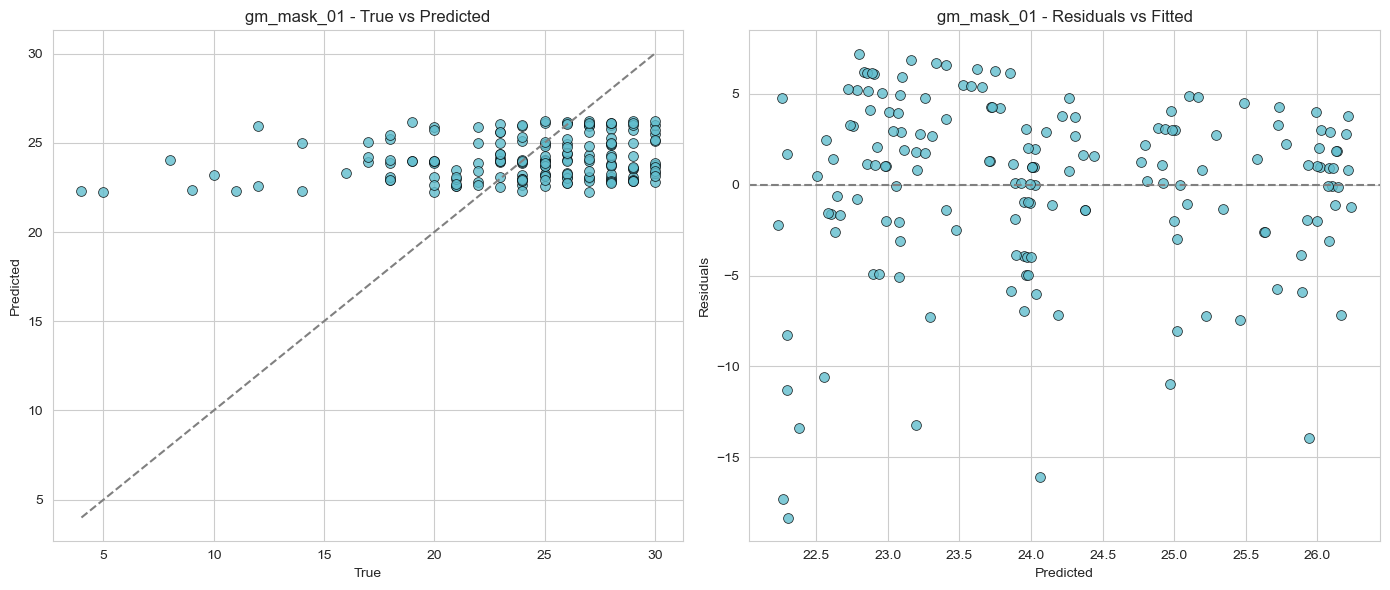

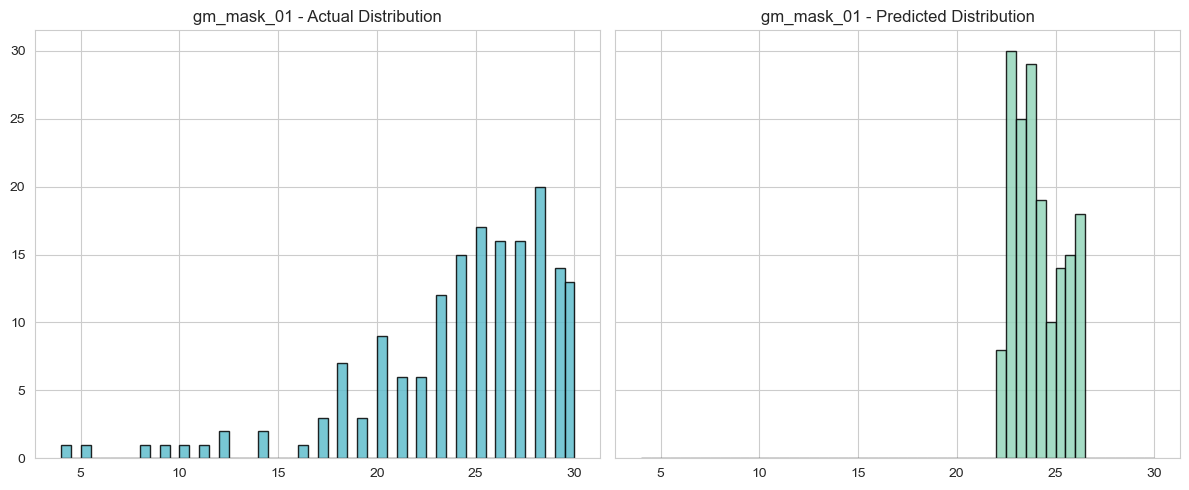

                            OLS Regression Results                            
Dep. Variable:                   MMSE   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     5.041
Date:                Thu, 29 May 2025   Prob (F-statistic):            0.00750
Time:                        18:49:04   Log-Likelihood:                -504.34
No. Observations:                 168   AIC:                             1015.
Df Residuals:                     165   BIC:                             1024.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.6908      1.765     11.155      0.0

In [47]:
model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
    df_masked = df_thr01_gm_masked,
    df_meta = df_meta,
    target_variable = target_col,
    covariates = None,
    y_log_transform = False,
    plot_flag = plot_flag_regression,
    save_path = path_umap_regression,
    title_prefix = "gm_mask_01"
)

Dataframe shape after merge: (171, 161825)
Meta columns: 8
Feature matrix shape: (171, 161817) 



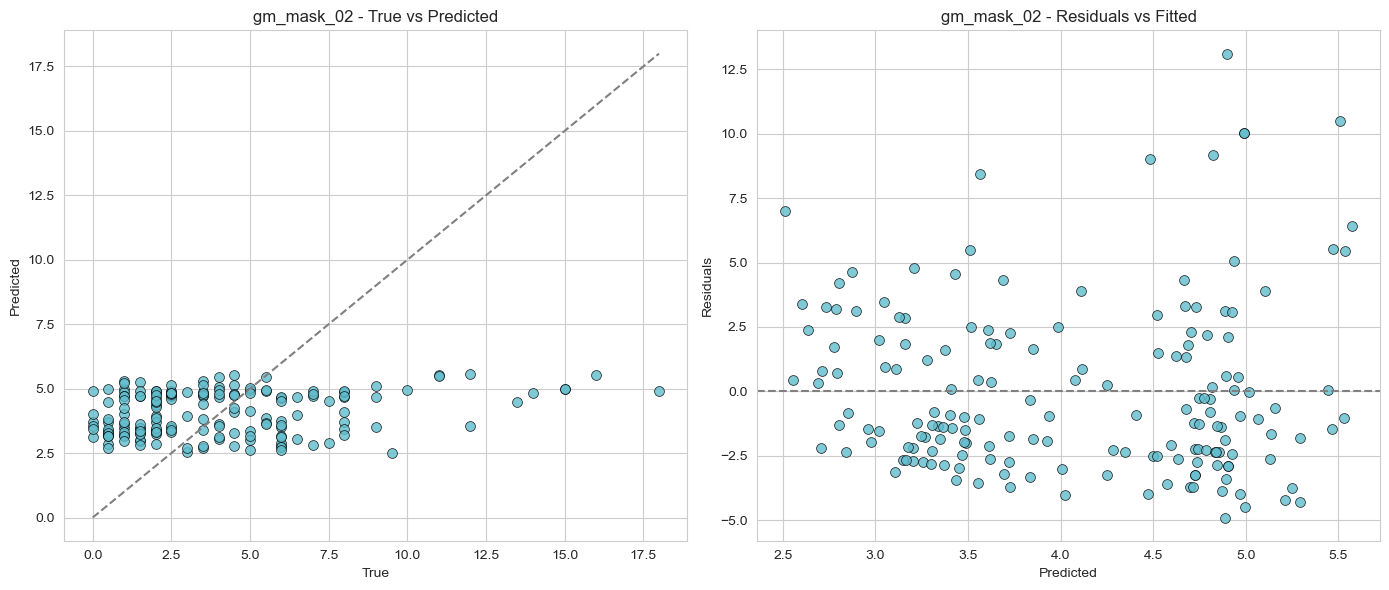

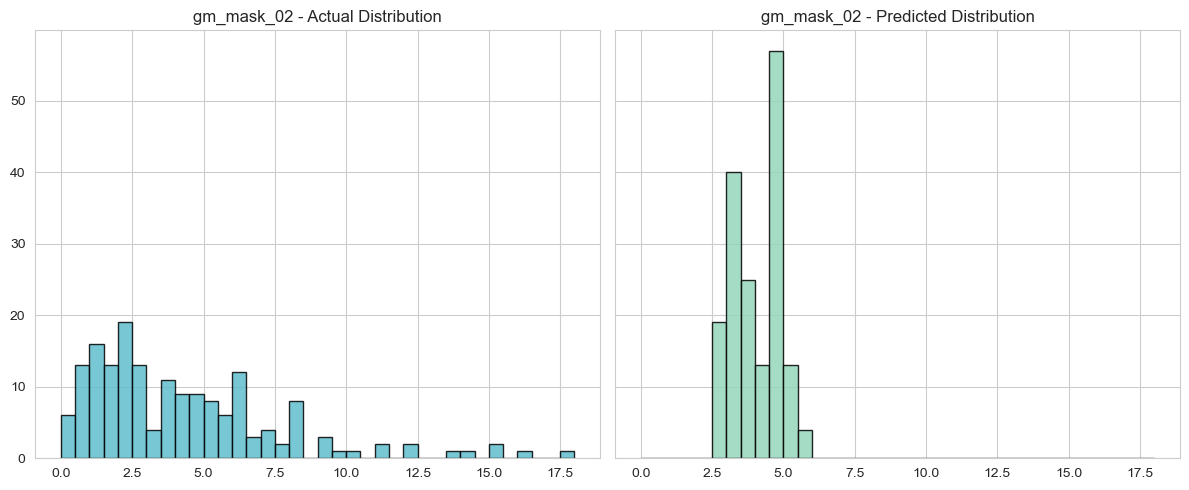

                            OLS Regression Results                            
Dep. Variable:                 CDR_SB   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     5.364
Date:                Thu, 29 May 2025   Prob (F-statistic):            0.00552
Time:                        18:50:53   Log-Likelihood:                -448.05
No. Observations:                 171   AIC:                             902.1
Df Residuals:                     168   BIC:                             911.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.6959      2.497      3.883      0.0

In [49]:
model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
    df_masked = df_thr02_gm_masked,
    df_meta = df_meta,
    target_variable = target_col,
    covariates = None,
    y_log_transform = False,
    plot_flag = plot_flag_regression,
    save_path = path_umap_regression,
    title_prefix = "gm_mask_02"
)

##### Harvard Mask

Dataframe shape after merge: (171, 55012)
Meta columns: 8
Feature matrix shape: (171, 55004) 



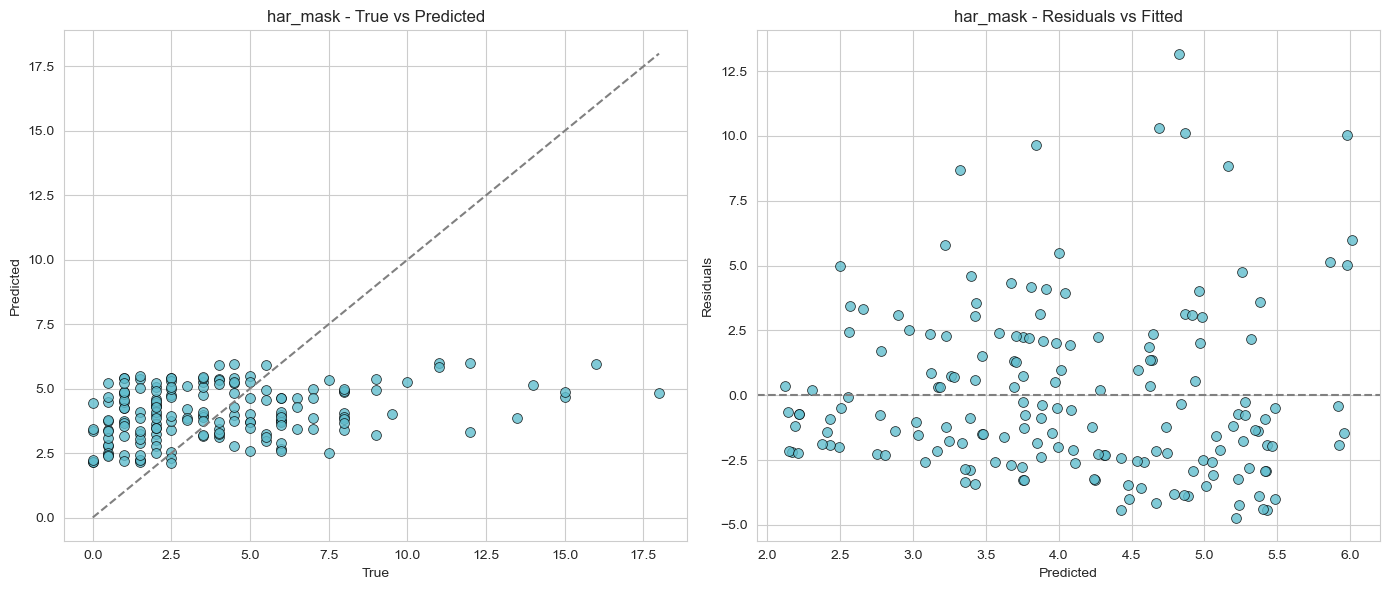

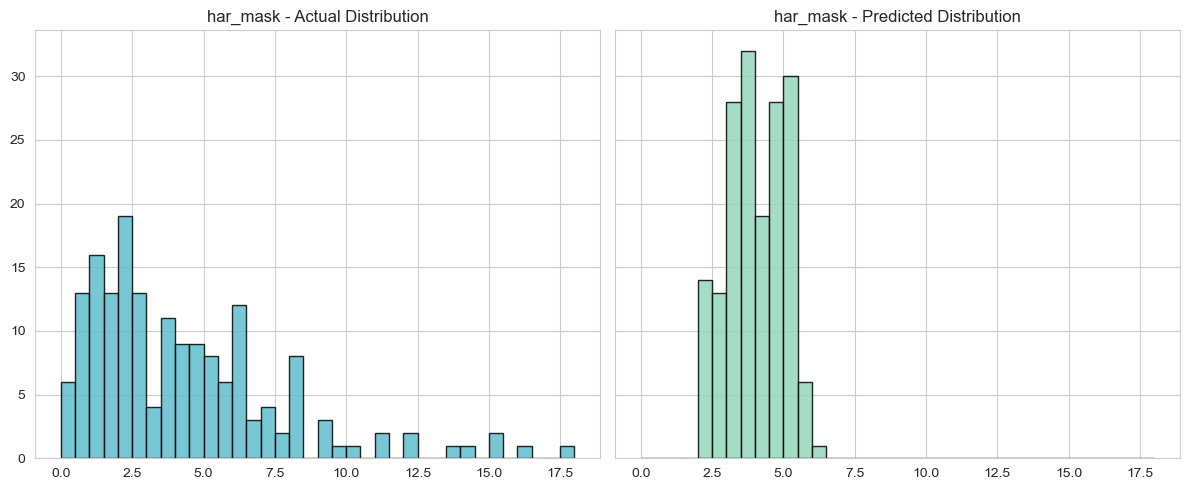

                            OLS Regression Results                            
Dep. Variable:                 CDR_SB   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     7.998
Date:                Thu, 29 May 2025   Prob (F-statistic):           0.000481
Time:                        18:51:27   Log-Likelihood:                -445.57
No. Observations:                 171   AIC:                             897.1
Df Residuals:                     168   BIC:                             906.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.4333      2.609      5.532      0.0

In [50]:
model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
    df_masked = df_har_masked,
    df_meta = df_meta,
    target_variable = target_col,
    covariates = None,
    y_log_transform = False,
    plot_flag = plot_flag_regression,
    save_path = path_umap_regression,
    title_prefix = "har_mask"
)

Dataframe shape after merge: (171, 55012)
Meta columns: 8
Feature matrix shape: (171, 55004) 



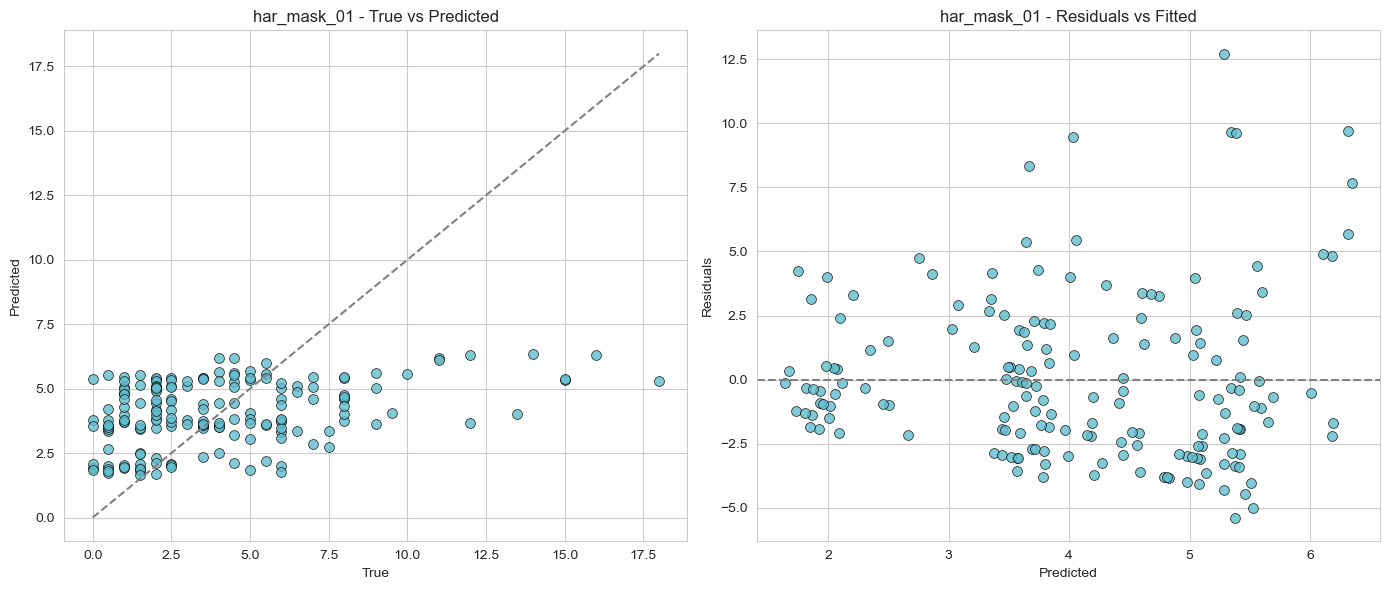

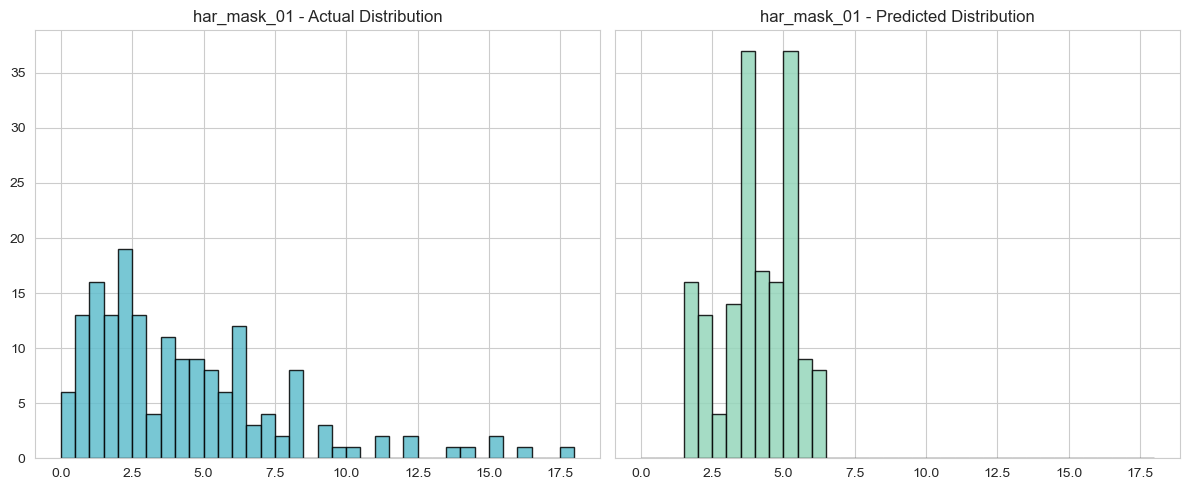

                            OLS Regression Results                            
Dep. Variable:                 CDR_SB   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     12.76
Date:                Thu, 29 May 2025   Prob (F-statistic):           6.90e-06
Time:                        18:51:49   Log-Likelihood:                -441.25
No. Observations:                 171   AIC:                             888.5
Df Residuals:                     168   BIC:                             897.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8039      1.714      1.636      0.1

In [51]:
model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
    df_masked = df_thr01_har_masked,
    df_meta = df_meta,
    target_variable = target_col,
    covariates = None,
    y_log_transform = False,
    plot_flag = plot_flag_regression,
    save_path = path_umap_regression,
    title_prefix = "har_mask_01"
)

Dataframe shape after merge: (171, 55012)
Meta columns: 8
Feature matrix shape: (171, 55004) 



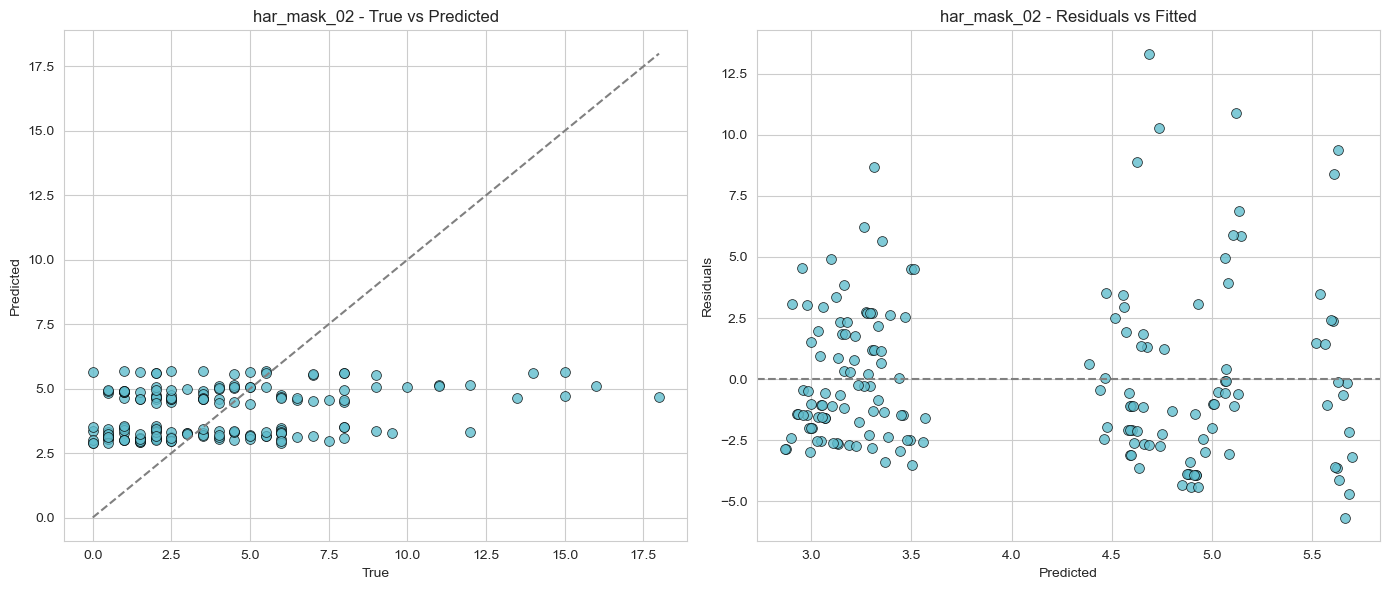

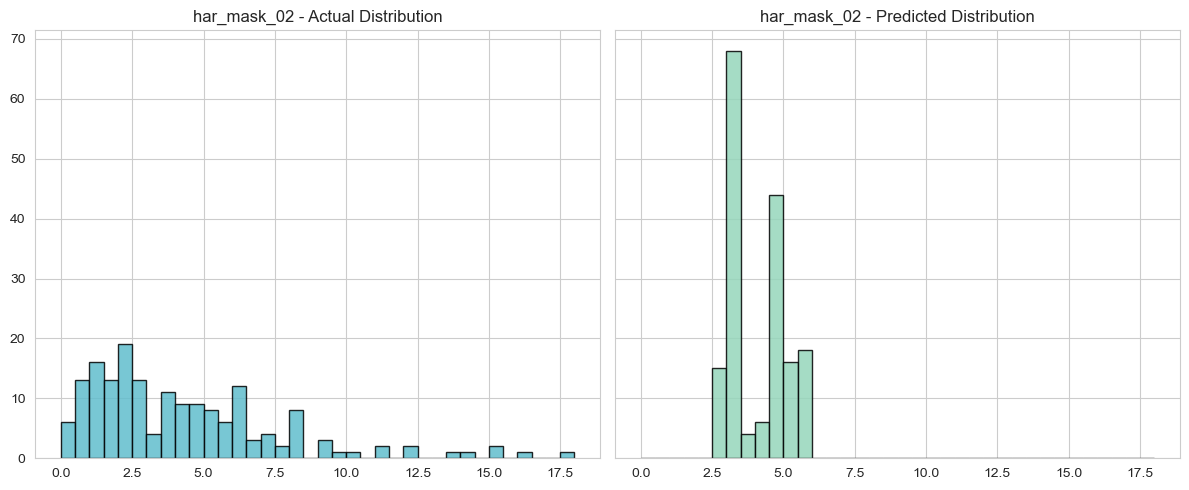

                            OLS Regression Results                            
Dep. Variable:                 CDR_SB   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     6.798
Date:                Thu, 29 May 2025   Prob (F-statistic):            0.00145
Time:                        18:52:09   Log-Likelihood:                -446.69
No. Observations:                 171   AIC:                             899.4
Df Residuals:                     168   BIC:                             908.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3186      3.736      0.085      0.9

In [52]:
model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
    df_masked = df_thr02_har_masked,
    df_meta = df_meta,
    target_variable = target_col,
    covariates = None,
    y_log_transform = False,
    plot_flag = plot_flag_regression,
    save_path = path_umap_regression,
    title_prefix = "har_mask_02"
)

##### Txt files

In [54]:
output_file = "/output/umap_regression_CDR_SB/OLS_regression_GM_mask.txt"

with open(output_file, "w") as f:
    with contextlib.redirect_stdout(f):
        print("\n\n" + "="*70)
        print("   OLS Regression Results - GM Mask without Threshold ")
        print("="*70 + "\n")

        model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
            df_masked = df_gm_masked,
            df_meta = df_meta,
            target_variable = target_col,
            covariates = None,
            y_log_transform = False,
            plot_flag = False,
            save_path = None,
        )

        print("\n\n\n" + "="*70)
        print("   OLS Regression Results - GM Mask without Threshold ")
        print("   Covariates: Sex, Education, Age ")
        print("="*70 + "\n")

        model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
            df_masked = df_gm_masked,
            df_meta = df_meta,
            target_variable = target_col,
            covariates = ["Sex", "Education", "Age"],
            y_log_transform = False,
            plot_flag = False,
            save_path = None,
        )

        print("\n\n" + "="*70)
        print("   OLS Regression Results - GM Mask with Threshold 0.2 ")
        print("="*70 + "\n")

        model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
            df_masked = df_thr02_gm_masked,
            df_meta = df_meta,
            target_variable = target_col,
            covariates = None,
            y_log_transform = False,
            plot_flag = False,
            save_path = None,
        )

        print("\n\n\n" + "="*70)
        print("   OLS Regression Results - GM Mask with Threshold 0.2 ")
        print("   Covariates: Sex, Education, Age ")
        print("="*70 + "\n")

        model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
            df_masked = df_thr02_gm_masked,
            df_meta = df_meta,
            target_variable = target_col,
            covariates = ["Sex", "Education", "Age"],
            y_log_transform = False,
            plot_flag = False,
            save_path = None,
        )

        print("\n\n" + "="*70)
        print("   OLS Regression Results - GM Mask with Threshold 0.1 ")
        print("="*70 + "\n")

        model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
            df_masked = df_thr01_gm_masked,
            df_meta = df_meta,
            target_variable = target_col,
            covariates = None,
            y_log_transform = False,
            plot_flag = False,
            save_path = None,
        )

        print("\n\n\n" + "="*70)
        print("   OLS Regression Results - GM Mask with Threshold 0.1 ")
        print("   Covariates: Sex, Education, Age ")
        print("="*70 + "\n")

        model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
            df_masked = df_thr01_gm_masked,
            df_meta = df_meta,
            target_variable = target_col,
            covariates = ["Sex", "Education", "Age"],
            y_log_transform = False,
            plot_flag = False,
            save_path = None,
        )


In [55]:
output_file = "/output/umap_regression_CDR_SB/OLS_regression_HAR_mask.txt"

with open(output_file, "w") as f:
    with contextlib.redirect_stdout(f):
        print("\n\n" + "="*70)
        print("   OLS Regression Results - Harvard Mask without Threshold ")
        print("="*70 + "\n")

        model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
            df_masked = df_har_masked,
            df_meta = df_meta,
            target_variable = target_col,
            covariates = None,
            y_log_transform = False,
            plot_flag = False,
            save_path = None,
        )

        print("\n\n\n" + "="*70)
        print("   OLS Regression Results - Harvard Mask without Threshold ")
        print("   Covariates: Sex, Education, Age ")
        print("="*70 + "\n")

        model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
            df_masked = df_har_masked,
            df_meta = df_meta,
            target_variable = target_col,
            covariates = ["Sex", "Education", "Age"],
            y_log_transform = False,
            plot_flag = False,
            save_path = None,
        )

        print("\n\n" + "="*70)
        print("   OLS Regression Results - Harvard Mask with Threshold 0.2 ")
        print("="*70 + "\n")

        model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
            df_masked = df_thr02_har_masked,
            df_meta = df_meta,
            target_variable = target_col,
            covariates = None,
            y_log_transform = False,
            plot_flag = False,
            save_path = None,
        )

        print("\n\n\n" + "="*70)
        print("   OLS Regression Results - Harvard Mask with Threshold 0.2 ")
        print("   Covariates: Sex, Education, Age ")
        print("="*70 + "\n")

        model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
            df_masked = df_thr02_har_masked,
            df_meta = df_meta,
            target_variable = target_col,
            covariates = ["Sex", "Education", "Age"],
            y_log_transform = False,
            plot_flag = False,
            save_path = None,
        )

        print("\n\n" + "="*70)
        print("   OLS Regression Results - Harvard Mask with Threshold 0.1 ")
        print("="*70 + "\n")

        model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
            df_masked = df_thr01_har_masked,
            df_meta = df_meta,
            target_variable = target_col,
            covariates = None,
            y_log_transform = False,
            plot_flag = False,
            save_path = None,
        )

        print("\n\n\n" + "="*70)
        print("   OLS Regression Results - Harvard Mask with Threshold 0.1 ")
        print("   Covariates: Sex, Education, Age ")
        print("="*70 + "\n")

        model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
            df_masked = df_thr01_har_masked,
            df_meta = df_meta,
            target_variable = target_col,
            covariates = ["Sex", "Education", "Age"],
            y_log_transform = False,
            plot_flag = False,
            save_path = None,
        )


##### GMM Distributions

In [ ]:
for gmmLabel in range(0,3):
    mean_cdr = df_meta.loc[df_meta['GMM_Label'] == gmmLabel, 'CDR_SB'].mean()
    print(f"Media CDR_SB per gruppo {gmmLabel}: {mean_cdr:.3f}")


# Select the subjects ID with a particular GMM_Label
gmm_ids = df_meta[df_meta['GMM_Label'] == 0]['ID']

# Filter the dataset
df_features = df_thr02_har_masked.copy()

df_masked_gmm = df_features[df_features['ID'].isin(gmm_ids)].reset_index(drop=True)
df_meta_gmm = df_meta[df_meta['ID'].isin(gmm_ids)].reset_index(drop=True)

In [ ]:
model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
    df_masked = df_masked_gmm,
    df_meta = df_meta_gmm,
    target_variable = "CDR_SB",
    covariates = None,
    y_log_transform = False,
    plot_flag = True,
    save_path = None,
    title_prefix = "gm_mask_GMM"
)

#### Yeo Networks

In [77]:
path_umap_regression = '/Users/emmatosato/Documents/PhD/ANM_Verona/output/umap_network_regression_CDR_SB'
target_col = "CDR_SB"

##### Networks 01

Dataframe shape after merge: (171, 16)
Meta columns: 8
Feature matrix shape: (171, 8) 



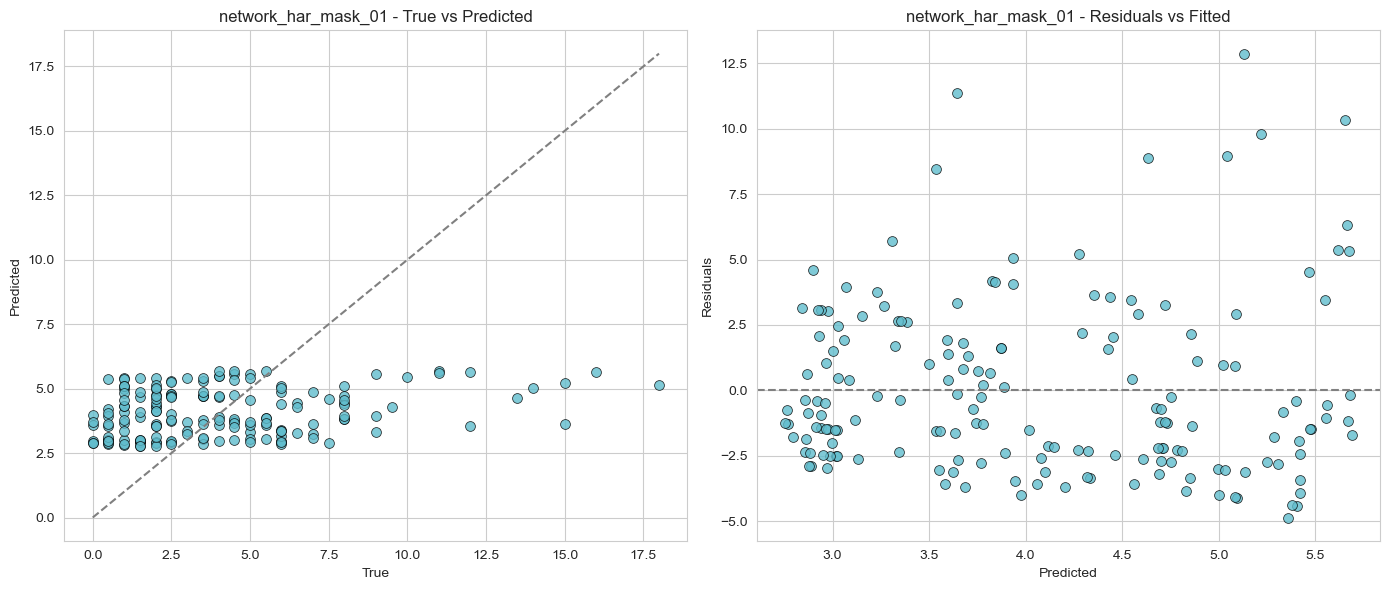

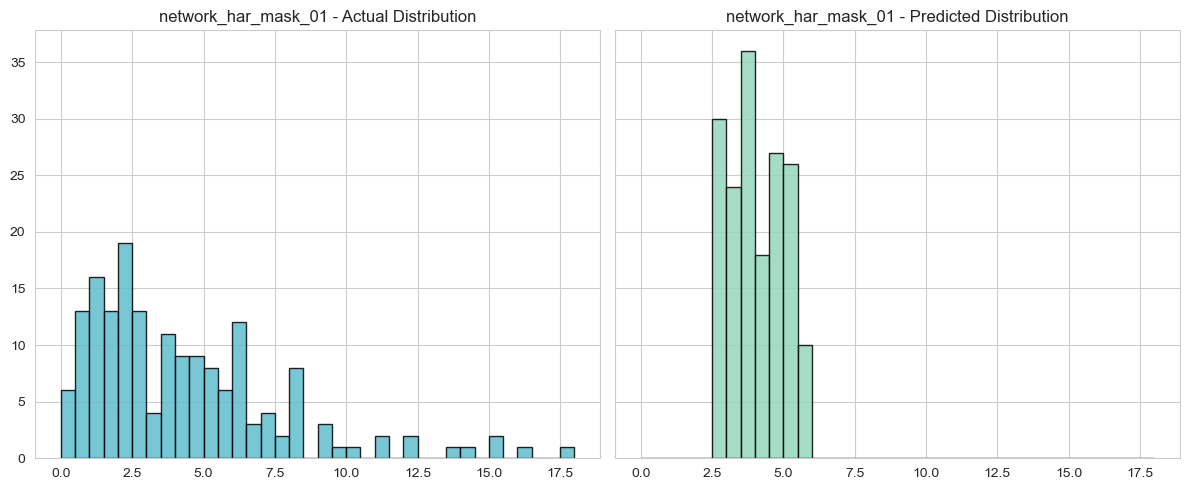

                            OLS Regression Results                            
Dep. Variable:                 CDR_SB   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     6.291
Date:                Thu, 29 May 2025   Prob (F-statistic):            0.00232
Time:                        19:51:44   Log-Likelihood:                -447.17
No. Observations:                 171   AIC:                             900.3
Df Residuals:                     168   BIC:                             909.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6375      0.706      5.150      0.0

In [78]:
model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
    df_masked = df_networks_thr01,
    df_meta = df_meta,
    target_variable = target_col,
    covariates = None,
    y_log_transform = False,
    plot_flag = plot_flag_regression,
    save_path = path_umap_regression,
    title_prefix = "network_har_mask_01"
)

##### Networks 02

Dataframe shape after merge: (171, 16)
Meta columns: 8
Feature matrix shape: (171, 8) 



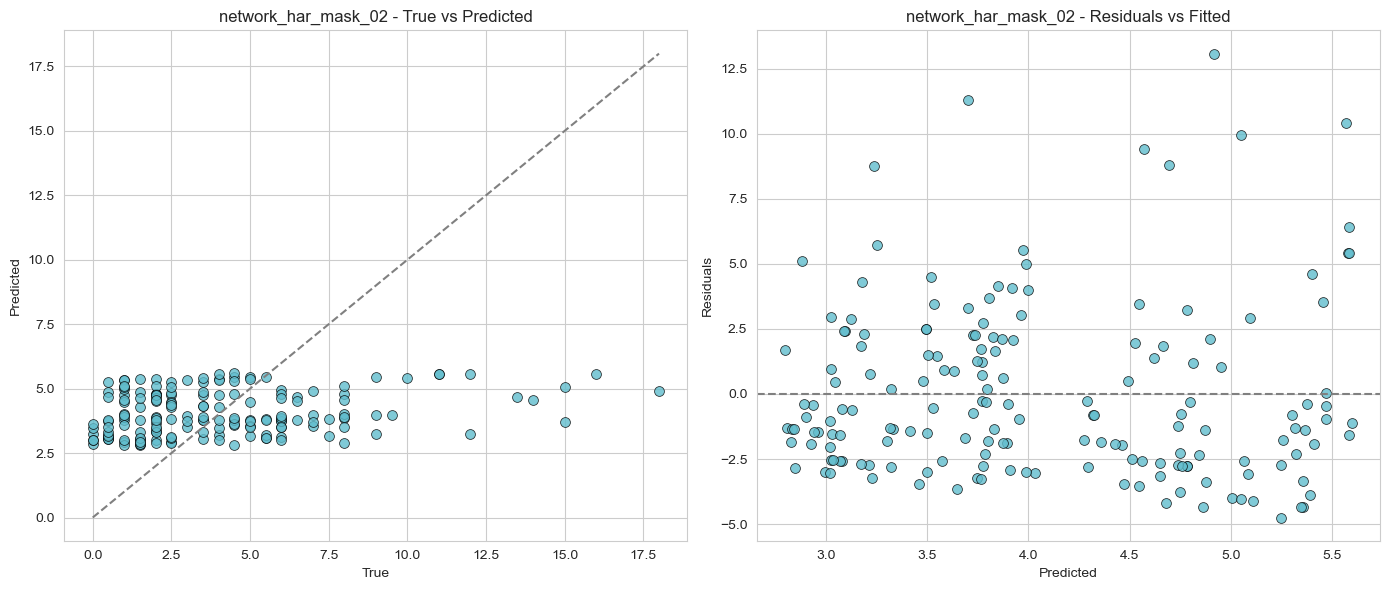

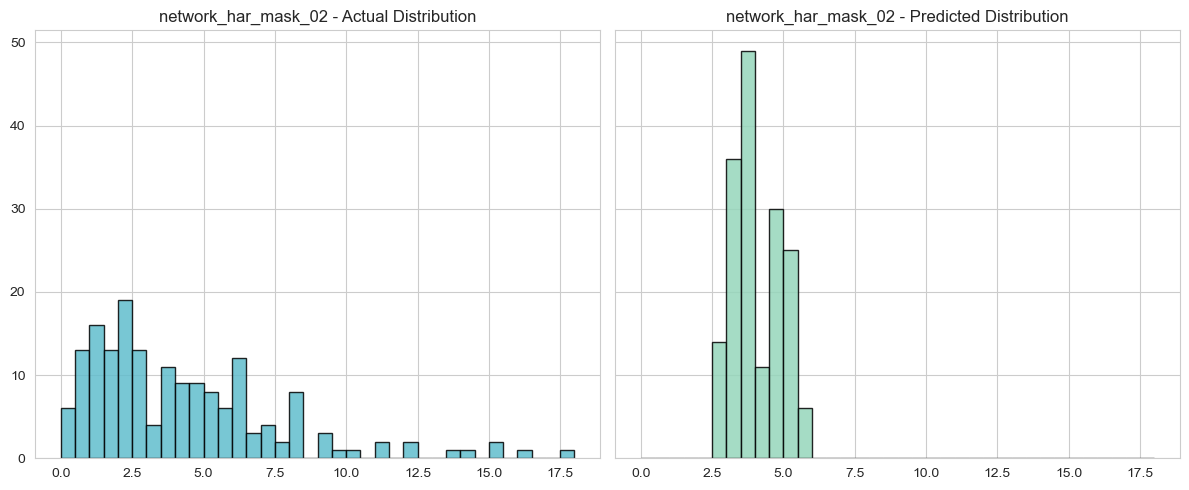

                            OLS Regression Results                            
Dep. Variable:                 CDR_SB   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     5.294
Date:                Thu, 29 May 2025   Prob (F-statistic):            0.00589
Time:                        19:52:00   Log-Likelihood:                -448.12
No. Observations:                 171   AIC:                             902.2
Df Residuals:                     168   BIC:                             911.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.5779      1.554      4.876      0.0

In [79]:
model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
    df_masked = df_networks_thr02,
    df_meta = df_meta,
    target_variable = target_col,
    covariates = None,
    y_log_transform = False,
    plot_flag = plot_flag_regression,
    save_path = path_umap_regression,
    title_prefix = "network_har_mask_02"
)

##### Networks no threshold

Dataframe shape after merge: (171, 16)
Meta columns: 8
Feature matrix shape: (171, 8) 



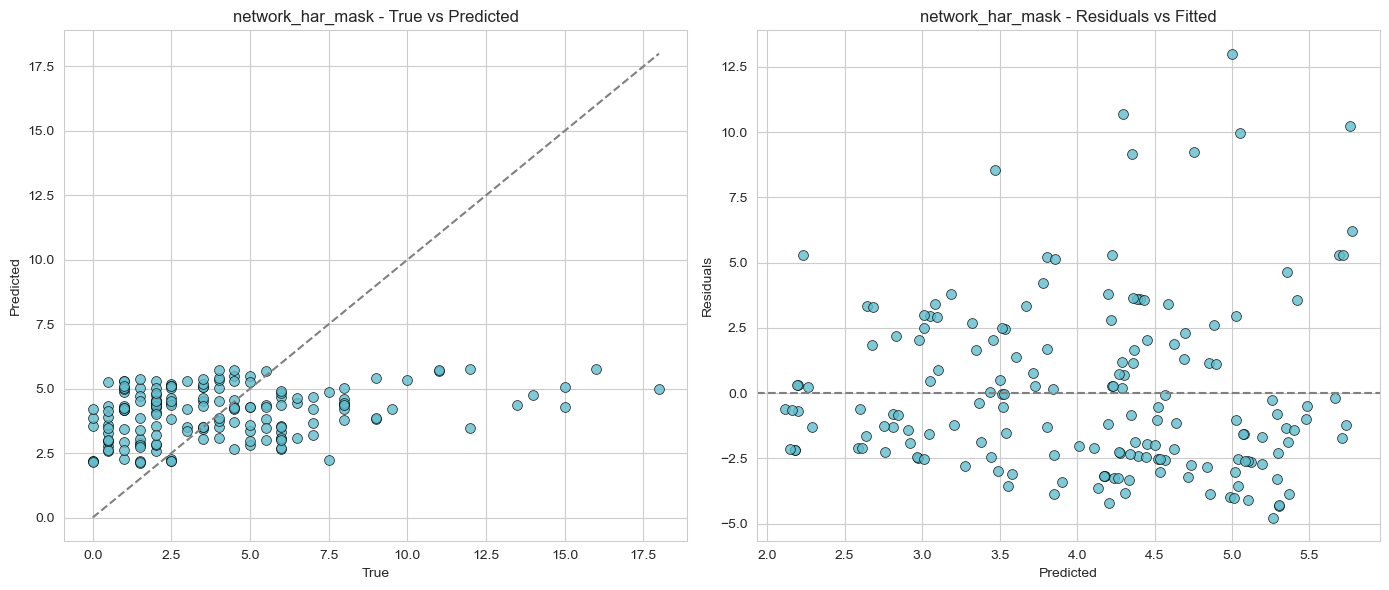

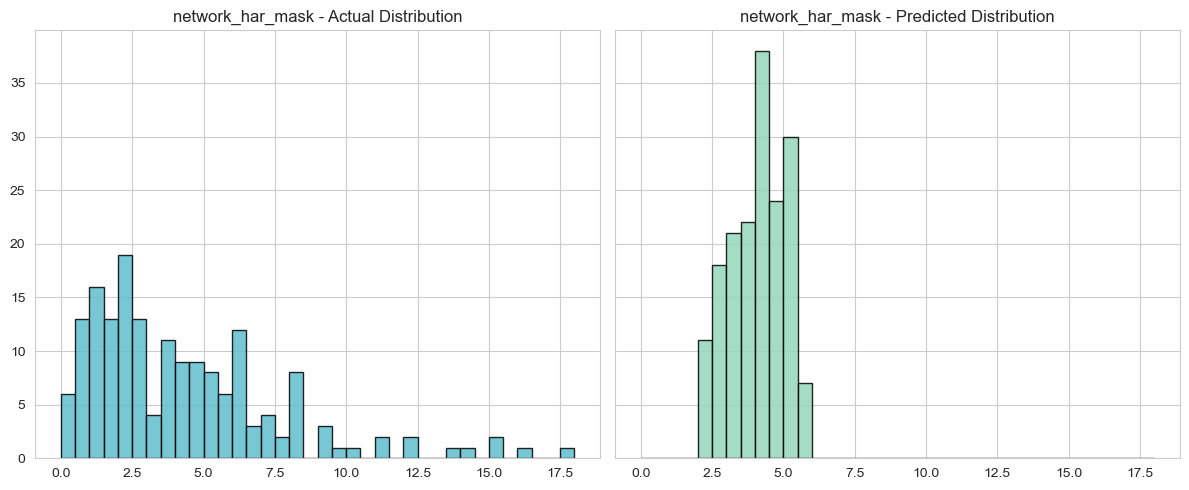

                            OLS Regression Results                            
Dep. Variable:                 CDR_SB   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     7.227
Date:                Thu, 29 May 2025   Prob (F-statistic):           0.000975
Time:                        19:52:02   Log-Likelihood:                -446.29
No. Observations:                 171   AIC:                             898.6
Df Residuals:                     168   BIC:                             908.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3332      0.649      9.758      0.0

In [80]:
model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
    df_masked = df_networks_no_thr,
    df_meta = df_meta,
    target_variable = target_col,
    covariates = None,
    y_log_transform = False,
    plot_flag = plot_flag_regression,
    save_path = path_umap_regression,
    title_prefix = "network_har_mask"
)

### Mini-Mental State

In [64]:
path_umap_regression = '/Users/emmatosato/Documents/PhD/ANM_Verona/output/umap_regression_MMSE'
target_col = "MMSE"

#### Voxel

##### GM Mask

Dataframe shape after merge: (168, 161825)
Meta columns: 8
Feature matrix shape: (168, 161817) 



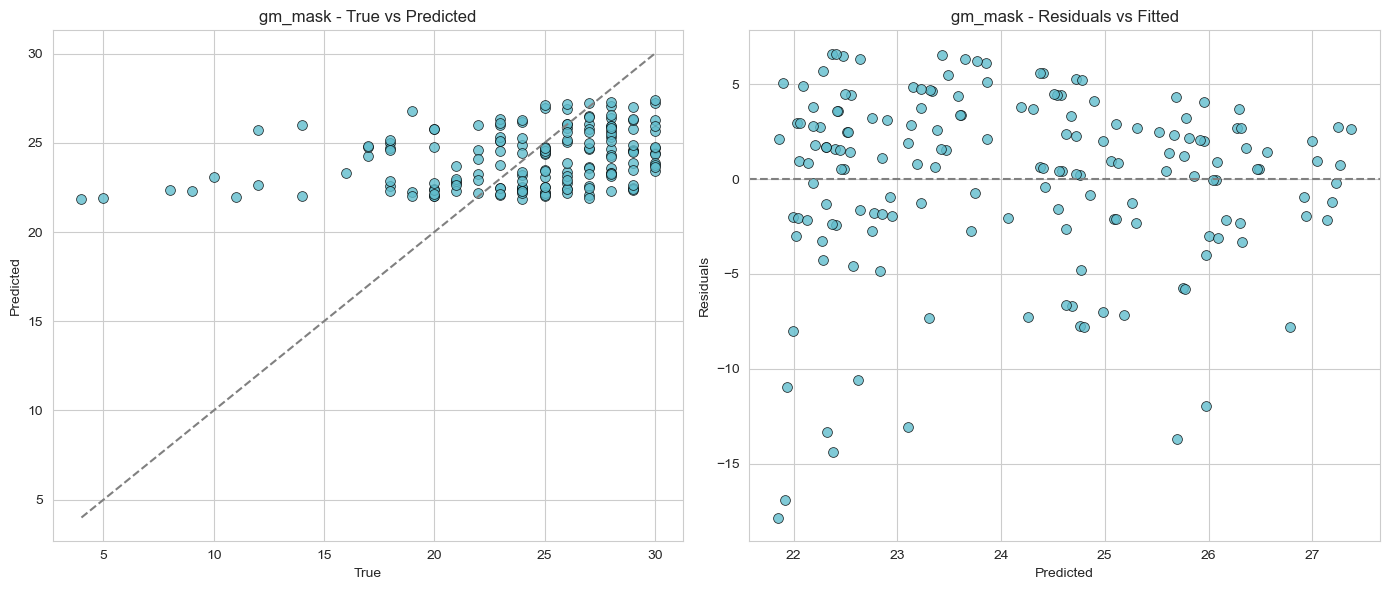

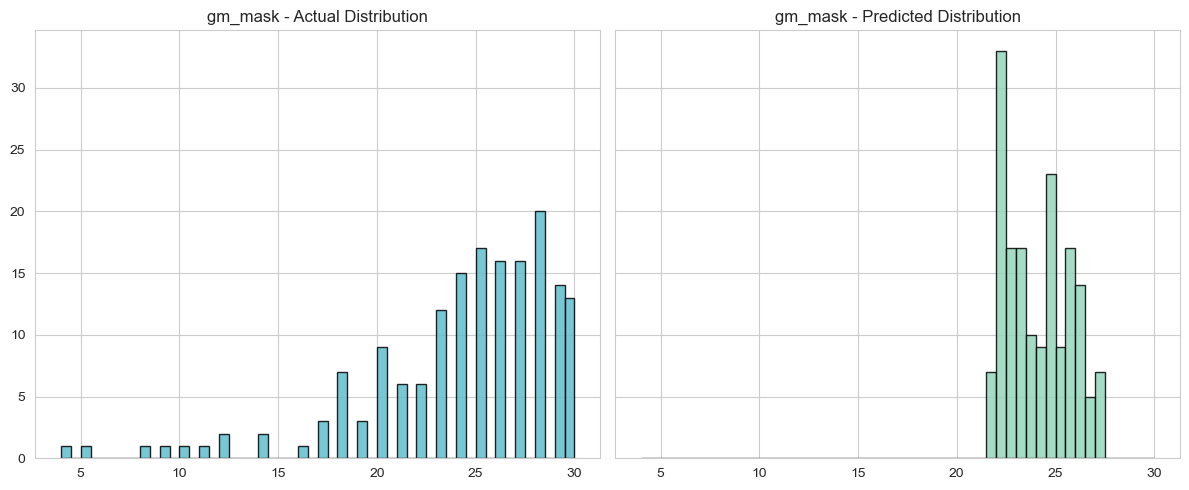

                            OLS Regression Results                            
Dep. Variable:                   MMSE   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     9.269
Date:                Thu, 29 May 2025   Prob (F-statistic):           0.000153
Time:                        19:39:02   Log-Likelihood:                -500.37
No. Observations:                 168   AIC:                             1007.
Df Residuals:                     165   BIC:                             1016.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.4675      3.199      3.272      0.0

In [65]:
model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
    df_masked = df_gm_masked,
    df_meta = df_meta,
    target_variable = target_col,
    covariates = None,
    y_log_transform = False,
    plot_flag = plot_flag_regression,
    save_path = path_umap_regression,
    title_prefix = "gm_mask"
)

Dataframe shape after merge: (168, 161825)
Meta columns: 8
Feature matrix shape: (168, 161817) 



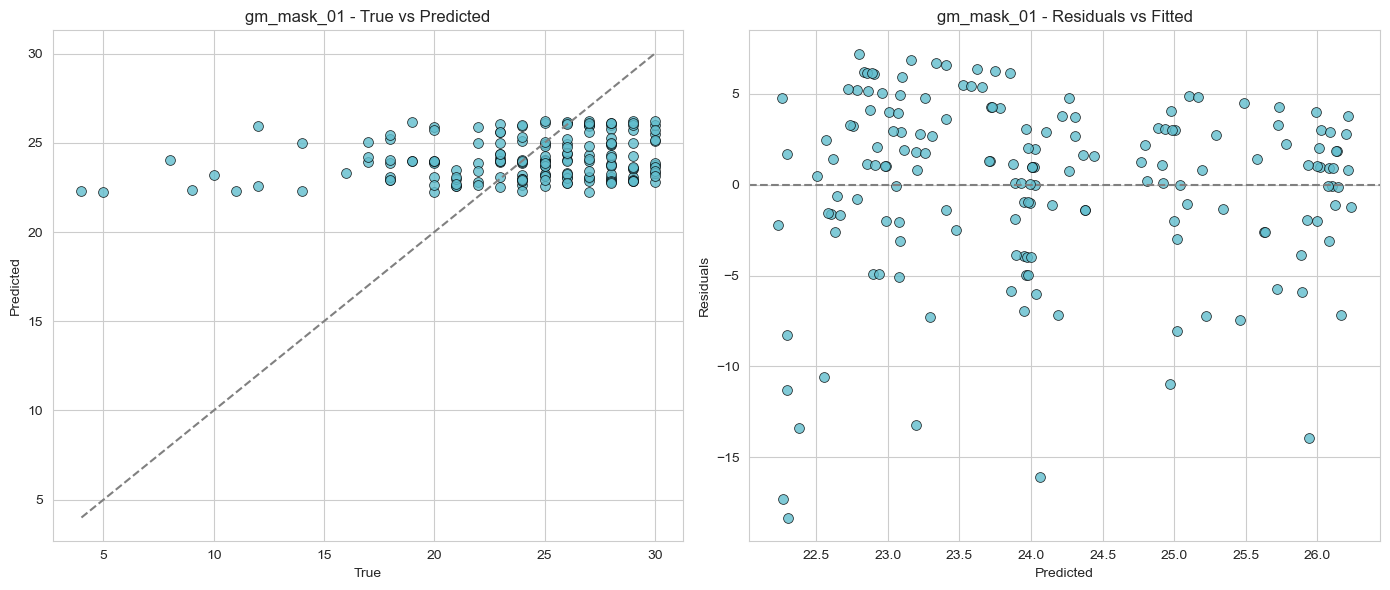

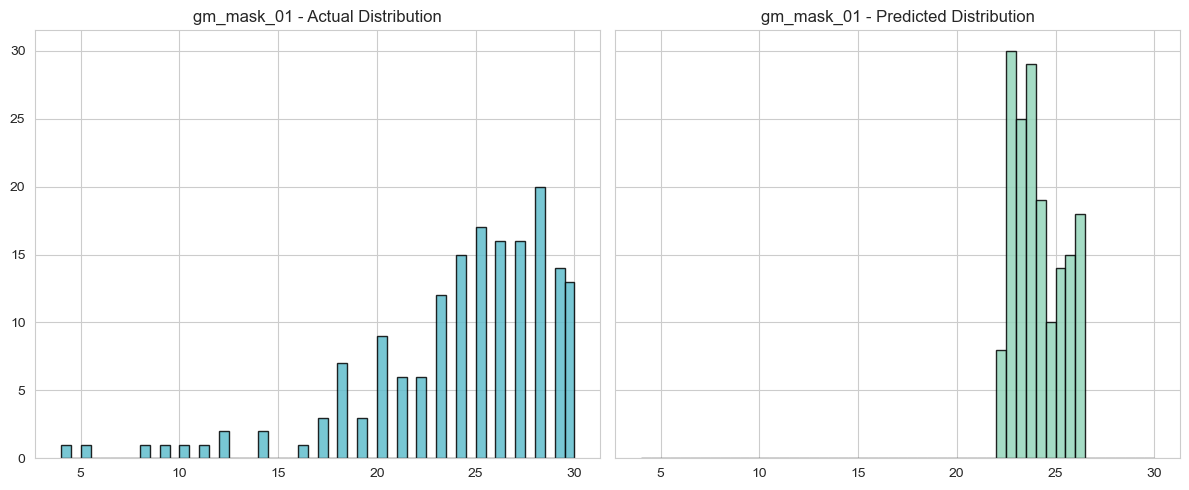

                            OLS Regression Results                            
Dep. Variable:                   MMSE   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     5.041
Date:                Thu, 29 May 2025   Prob (F-statistic):            0.00750
Time:                        19:39:06   Log-Likelihood:                -504.34
No. Observations:                 168   AIC:                             1015.
Df Residuals:                     165   BIC:                             1024.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.6908      1.765     11.155      0.0

In [66]:
model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
    df_masked = df_thr01_gm_masked,
    df_meta = df_meta,
    target_variable = target_col,
    covariates = None,
    y_log_transform = False,
    plot_flag = plot_flag_regression,
    save_path = path_umap_regression,
    title_prefix = "gm_mask_01"
)

Dataframe shape after merge: (168, 161825)
Meta columns: 8
Feature matrix shape: (168, 161817) 



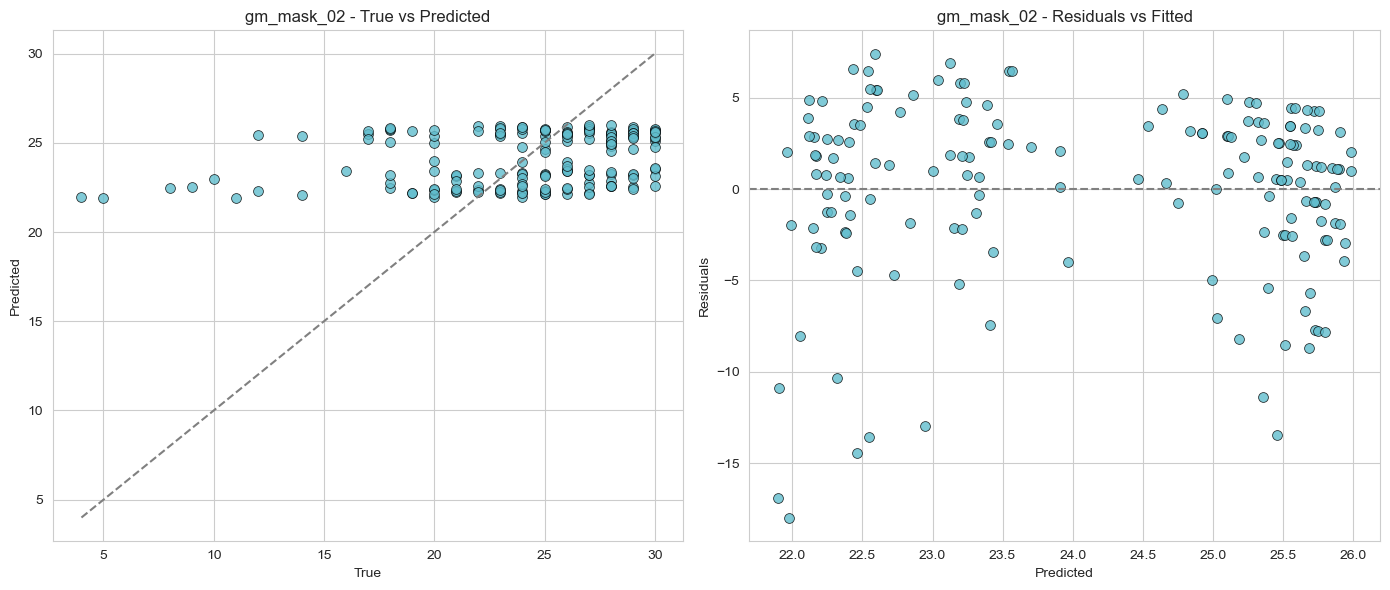

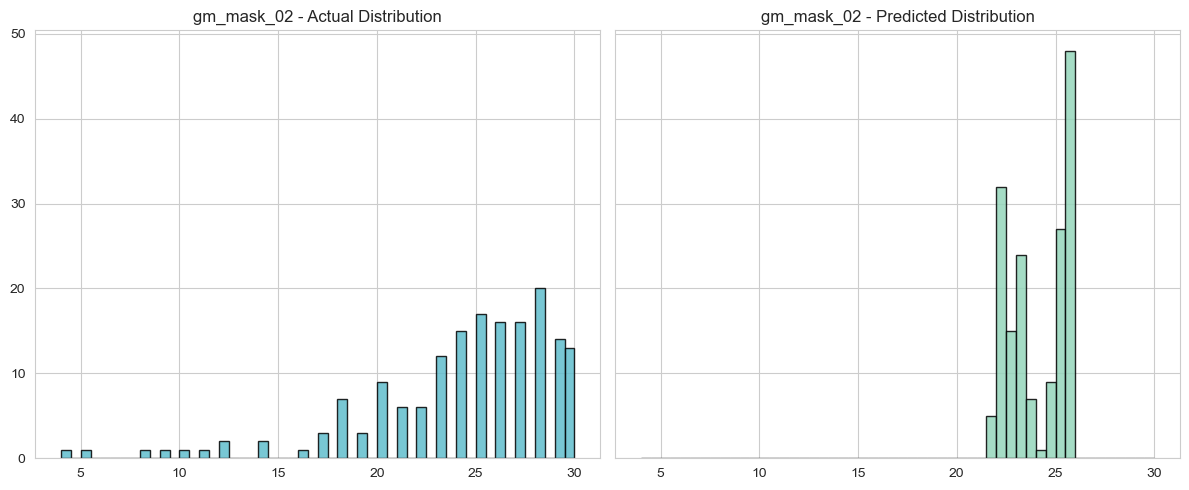

                            OLS Regression Results                            
Dep. Variable:                   MMSE   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     7.455
Date:                Thu, 29 May 2025   Prob (F-statistic):           0.000795
Time:                        19:39:12   Log-Likelihood:                -502.05
No. Observations:                 168   AIC:                             1010.
Df Residuals:                     165   BIC:                             1019.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.5821      1.354     14.459      0.0

In [67]:
model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
    df_masked = df_thr02_gm_masked,
    df_meta = df_meta,
    target_variable = target_col,
    covariates = None,
    y_log_transform = False,
    plot_flag = plot_flag_regression,
    save_path = path_umap_regression,
    title_prefix = "gm_mask_02"
)

##### Hardvard Mask

Dataframe shape after merge: (168, 55012)
Meta columns: 8
Feature matrix shape: (168, 55004) 



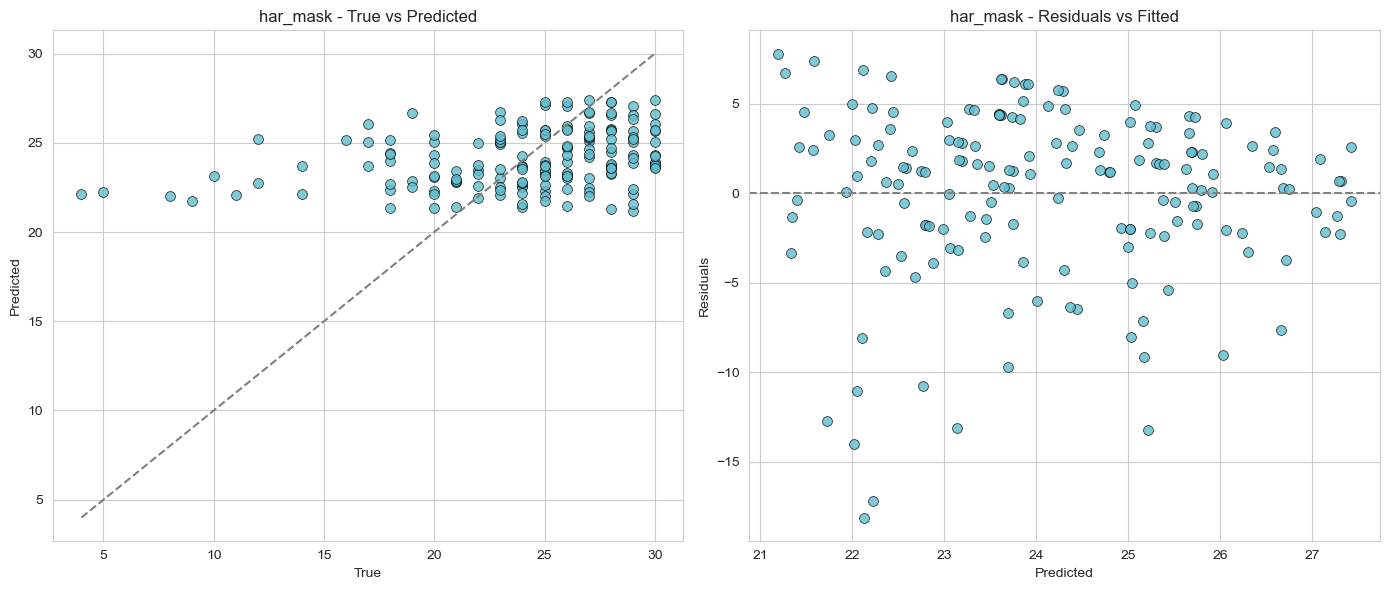

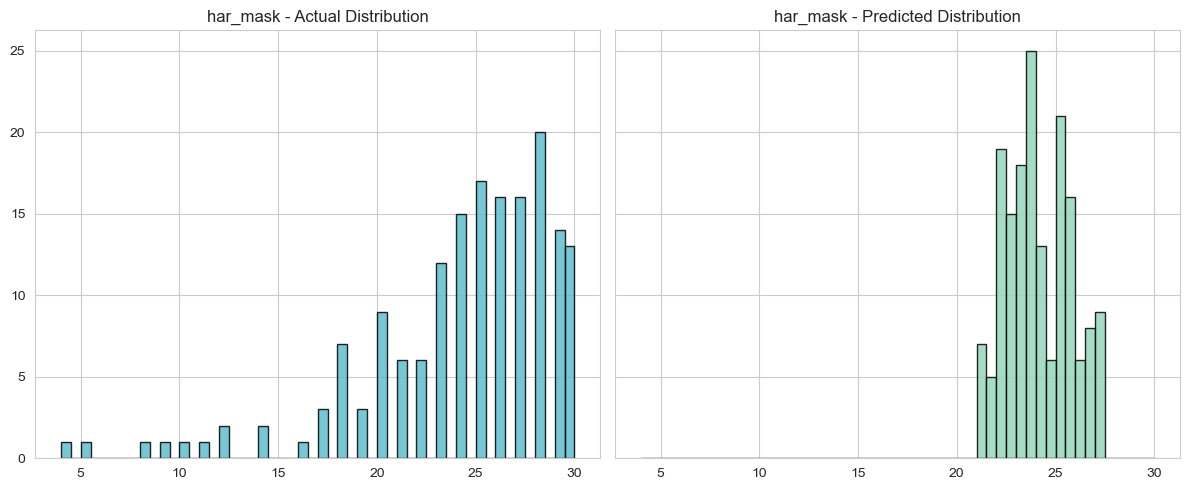

                            OLS Regression Results                            
Dep. Variable:                   MMSE   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     9.479
Date:                Thu, 29 May 2025   Prob (F-statistic):           0.000127
Time:                        19:39:44   Log-Likelihood:                -500.18
No. Observations:                 168   AIC:                             1006.
Df Residuals:                     165   BIC:                             1016.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.0695      1.987      8.086      0.0

In [68]:
model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
    df_masked = df_har_masked,
    df_meta = df_meta,
    target_variable = target_col,
    covariates = None,
    y_log_transform = False,
    plot_flag = plot_flag_regression,
    save_path = path_umap_regression,
    title_prefix = "har_mask"
)


Dataframe shape after merge: (168, 55012)
Meta columns: 8
Feature matrix shape: (168, 55004) 



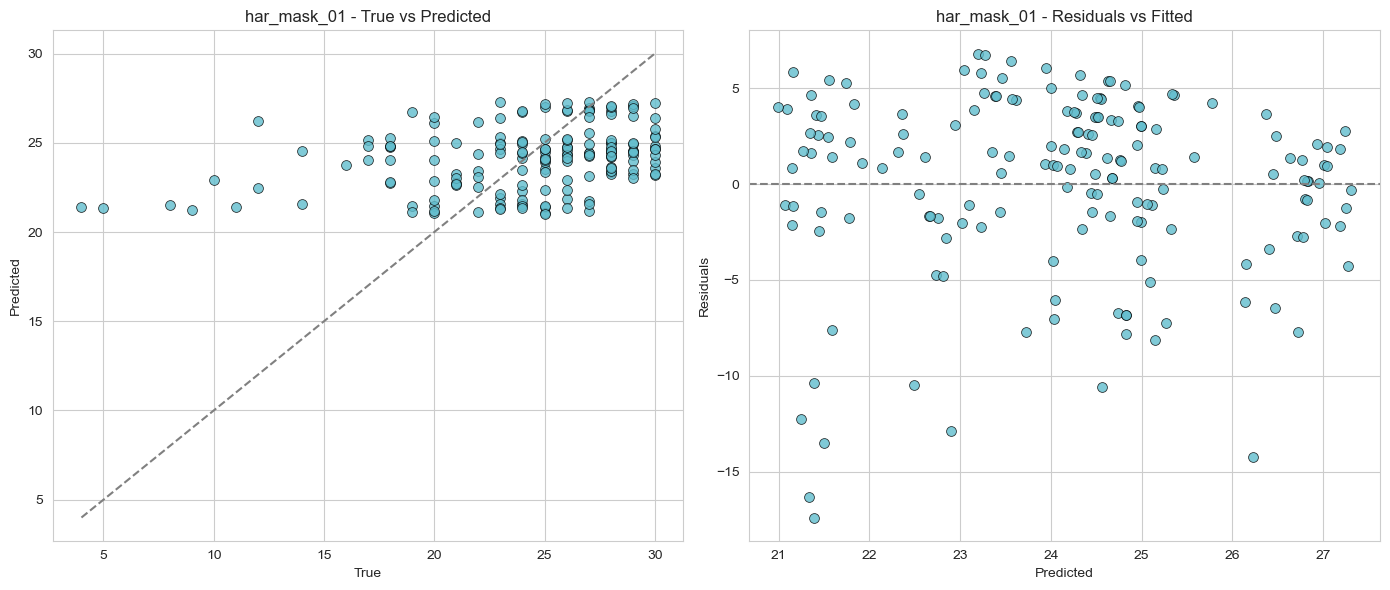

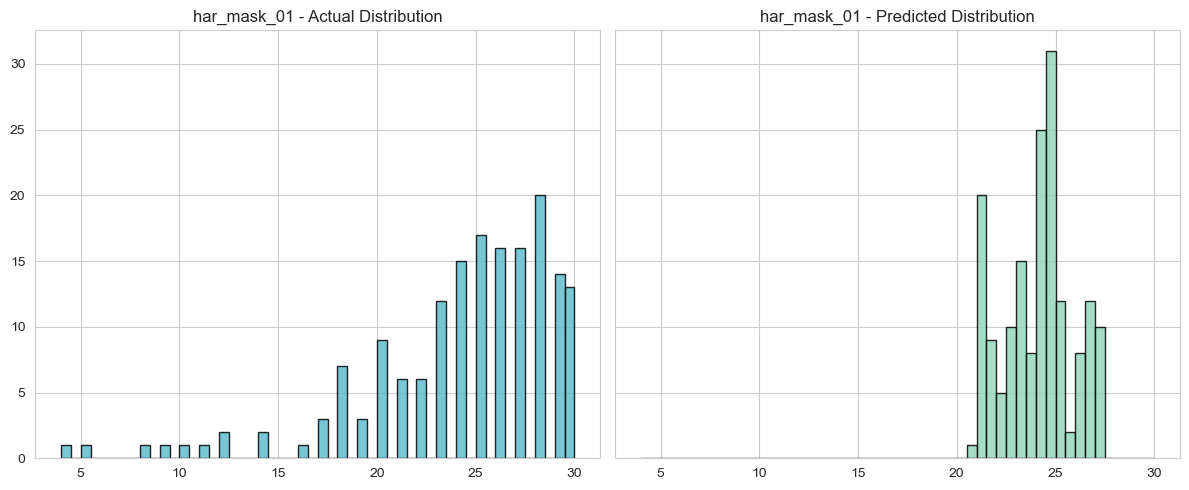

                            OLS Regression Results                            
Dep. Variable:                   MMSE   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     11.56
Date:                Thu, 29 May 2025   Prob (F-statistic):           2.00e-05
Time:                        19:39:46   Log-Likelihood:                -498.30
No. Observations:                 168   AIC:                             1003.
Df Residuals:                     165   BIC:                             1012.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.3235      2.480     11.822      0.0

In [69]:
model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
    df_masked = df_thr01_har_masked,
    df_meta = df_meta,
    target_variable = target_col,
    covariates = None,
    y_log_transform = False,
    plot_flag = plot_flag_regression,
    save_path = path_umap_regression,
    title_prefix = "har_mask_01"
)

Dataframe shape after merge: (168, 55012)
Meta columns: 8
Feature matrix shape: (168, 55004) 



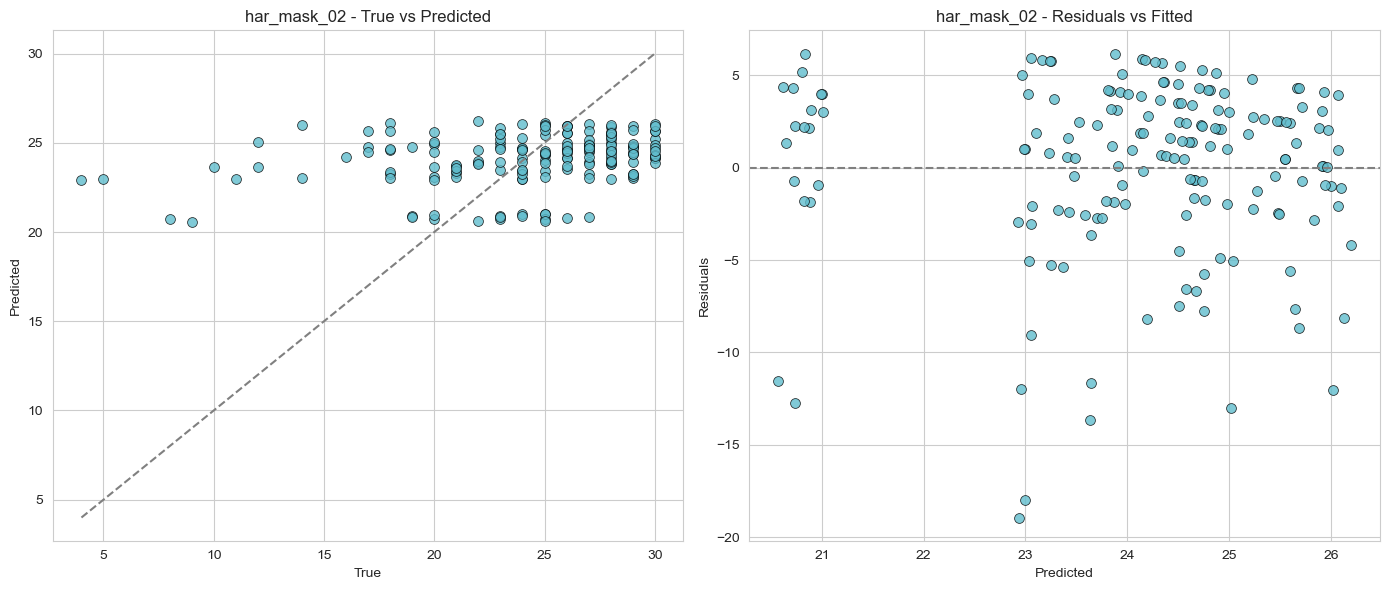

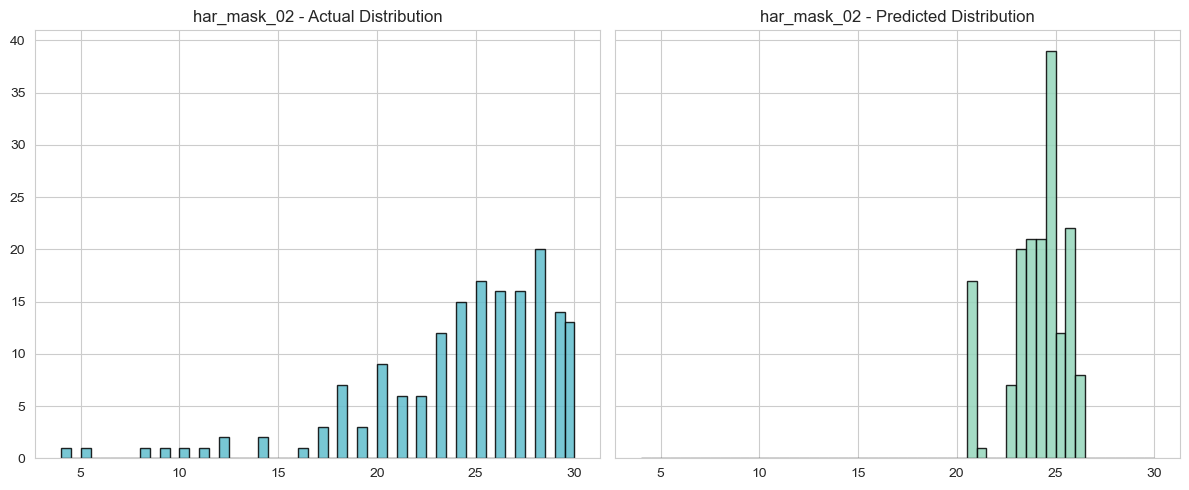

                            OLS Regression Results                            
Dep. Variable:                   MMSE   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     7.377
Date:                Thu, 29 May 2025   Prob (F-statistic):           0.000854
Time:                        19:39:49   Log-Likelihood:                -502.12
No. Observations:                 168   AIC:                             1010.
Df Residuals:                     165   BIC:                             1020.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         33.0893      4.969      6.659      0.0

In [70]:
model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
    df_masked = df_thr02_har_masked,
    df_meta = df_meta,
    target_variable = target_col,
    covariates = None,
    y_log_transform = False,
    plot_flag = plot_flag_regression,
    save_path = path_umap_regression,
    title_prefix = "har_mask_02"
)

##### Txt files

In [72]:
output_file = "/Users/emmatosato/Documents/PhD/ANM_Verona/output/umap_regression_MMSE/OLS_regression_GM_mask.txt"

with open(output_file, "w") as f:
    with contextlib.redirect_stdout(f):
        print("\n\n" + "="*70)
        print("   OLS Regression Results - GM Mask without Threshold ")
        print("="*70 + "\n")

        model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
            df_masked = df_gm_masked,
            df_meta = df_meta,
            target_variable = target_col,
            covariates = None,
            y_log_transform = False,
            plot_flag = False,
            save_path = None,
        )

        print("\n\n\n" + "="*70)
        print("   OLS Regression Results - GM Mask without Threshold ")
        print("   Covariates: Sex, Education, Age ")
        print("="*70 + "\n")

        model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
            df_masked = df_gm_masked,
            df_meta = df_meta,
            target_variable = target_col,
            covariates = ["Sex", "Education", "Age"],
            y_log_transform = False,
            plot_flag = False,
            save_path = None,
        )

        print("\n\n" + "="*70)
        print("   OLS Regression Results - GM Mask with Threshold 0.2 ")
        print("="*70 + "\n")

        model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
            df_masked = df_thr02_gm_masked,
            df_meta = df_meta,
            target_variable = target_col,
            covariates = None,
            y_log_transform = False,
            plot_flag = False,
            save_path = None,
        )

        print("\n\n\n" + "="*70)
        print("   OLS Regression Results - GM Mask with Threshold 0.2 ")
        print("   Covariates: Sex, Education, Age ")
        print("="*70 + "\n")

        model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
            df_masked = df_thr02_gm_masked,
            df_meta = df_meta,
            target_variable = target_col,
            covariates = ["Sex", "Education", "Age"],
            y_log_transform = False,
            plot_flag = False,
            save_path = None,
        )

        print("\n\n" + "="*70)
        print("   OLS Regression Results - GM Mask with Threshold 0.1 ")
        print("="*70 + "\n")

        model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
            df_masked = df_thr01_gm_masked,
            df_meta = df_meta,
            target_variable = target_col,
            covariates = None,
            y_log_transform = False,
            plot_flag = False,
            save_path = None,
        )

        print("\n\n\n" + "="*70)
        print("   OLS Regression Results - GM Mask with Threshold 0.1 ")
        print("   Covariates: Sex, Education, Age ")
        print("="*70 + "\n")

        model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
            df_masked = df_thr01_gm_masked,
            df_meta = df_meta,
            target_variable = target_col,
            covariates = ["Sex", "Education", "Age"],
            y_log_transform = False,
            plot_flag = False,
            save_path = None,
        )


In [73]:
output_file = "/Users/emmatosato/Documents/PhD/ANM_Verona/output/umap_regression_MMSE/OLS_regression_HAR_mask.txt"

with open(output_file, "w") as f:
    with contextlib.redirect_stdout(f):
        print("\n\n" + "="*70)
        print("   OLS Regression Results - Harvard Mask without Threshold ")
        print("="*70 + "\n")

        model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
            df_masked = df_har_masked,
            df_meta = df_meta,
            target_variable = target_col,
            covariates = None,
            y_log_transform = False,
            plot_flag = False,
            save_path = None,
        )

        print("\n\n\n" + "="*70)
        print("   OLS Regression Results - Harvard Mask without Threshold ")
        print("   Covariates: Sex, Education, Age ")
        print("="*70 + "\n")

        model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
            df_masked = df_har_masked,
            df_meta = df_meta,
            target_variable = target_col,
            covariates = ["Sex", "Education", "Age"],
            y_log_transform = False,
            plot_flag = False,
            save_path = None,
        )

        print("\n\n" + "="*70)
        print("   OLS Regression Results - Harvard Mask with Threshold 0.2 ")
        print("="*70 + "\n")

        model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
            df_masked = df_thr02_har_masked,
            df_meta = df_meta,
            target_variable = target_col,
            covariates = None,
            y_log_transform = False,
            plot_flag = False,
            save_path = None,
        )

        print("\n\n\n" + "="*70)
        print("   OLS Regression Results - Harvard Mask with Threshold 0.2 ")
        print("   Covariates: Sex, Education, Age ")
        print("="*70 + "\n")

        model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
            df_masked = df_thr02_har_masked,
            df_meta = df_meta,
            target_variable = target_col,
            covariates = ["Sex", "Education", "Age"],
            y_log_transform = False,
            plot_flag = False,
            save_path = None,
        )

        print("\n\n" + "="*70)
        print("   OLS Regression Results - Harvard Mask with Threshold 0.1 ")
        print("="*70 + "\n")

        model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
            df_masked = df_thr01_har_masked,
            df_meta = df_meta,
            target_variable = target_col,
            covariates = None,
            y_log_transform = False,
            plot_flag = False,
            save_path = None,
        )

        print("\n\n\n" + "="*70)
        print("   OLS Regression Results - Harvard Mask with Threshold 0.1 ")
        print("   Covariates: Sex, Education, Age ")
        print("="*70 + "\n")

        model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
            df_masked = df_thr01_har_masked,
            df_meta = df_meta,
            target_variable = target_col,
            covariates = ["Sex", "Education", "Age"],
            y_log_transform = False,
            plot_flag = False,
            save_path = None,
        )


##### Yeo Networks

In [99]:
target_col = "MMSE"
plot_flag_regression

Dataframe shape after merge: (168, 16)
Meta columns: 8
Feature matrix shape: (168, 8) 



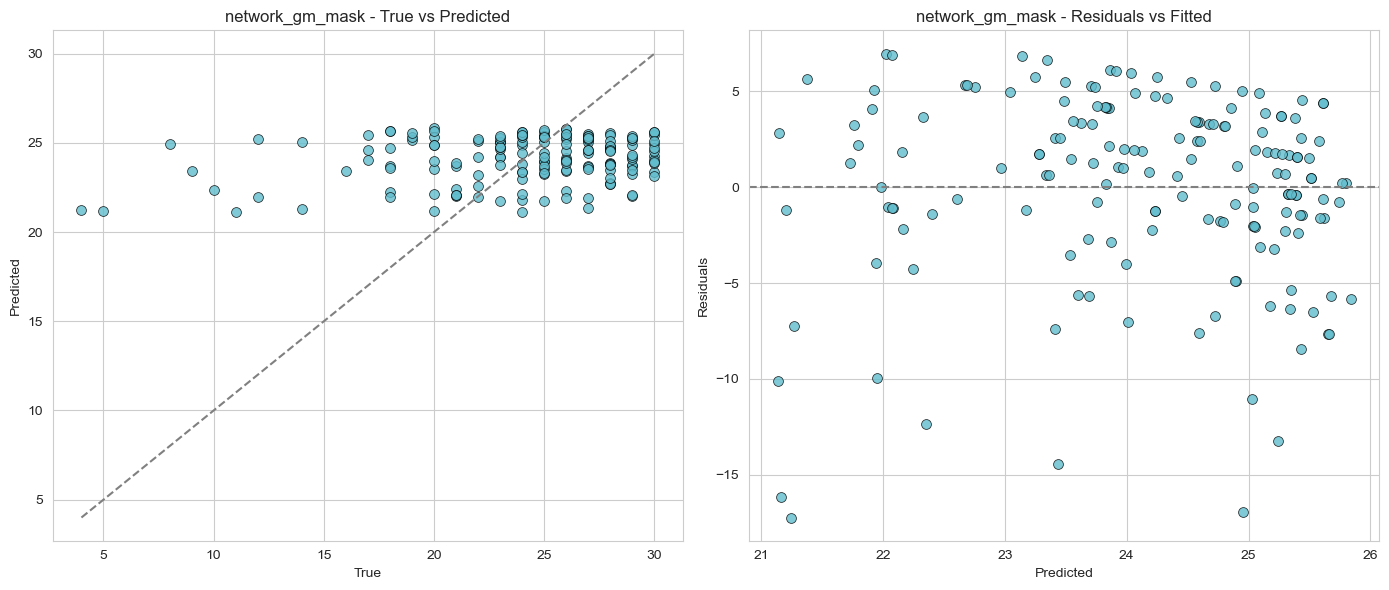

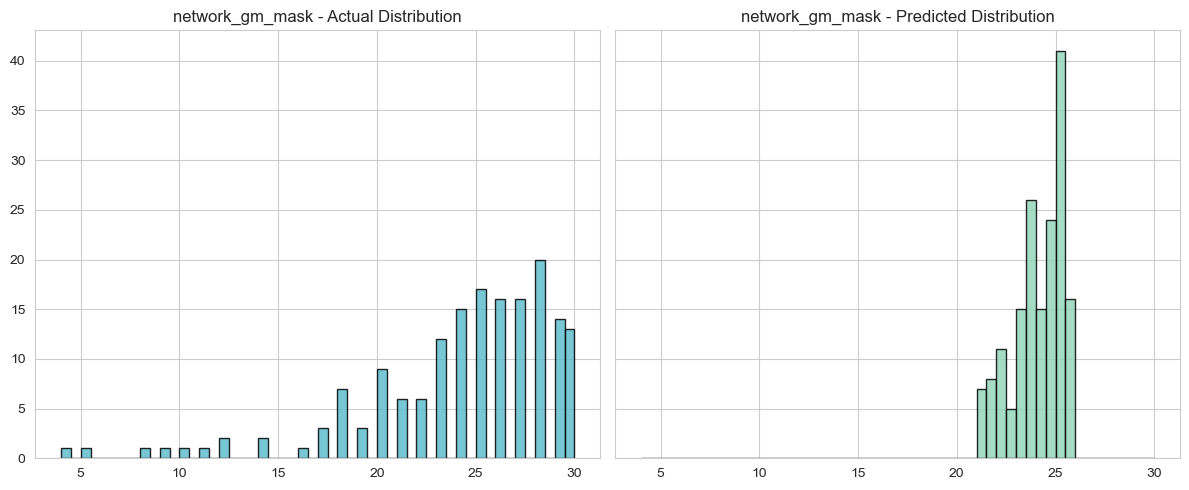

                            OLS Regression Results                            
Dep. Variable:                   MMSE   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     5.529
Date:                Fri, 30 May 2025   Prob (F-statistic):            0.00474
Time:                        11:15:01   Log-Likelihood:                -503.87
No. Observations:                 168   AIC:                             1014.
Df Residuals:                     165   BIC:                             1023.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.0866      0.976     27.739      0.0

In [100]:
model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
    df_masked = df_networks_no_thr,
    df_meta = df_meta,
    target_variable = target_col,
    covariates = None,
    y_log_transform = False,
    plot_flag = plot_flag_regression,
    save_path = None,
    title_prefix = "network_gm_mask"
)